# Presenting and evaluating benchmark models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import os

# Evaluation scripts
from CompetitionEvaluation import load_data, structure_data, calculate_metrics
 

In [3]:
# Where to find files
username = os.getlogin()
Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Tables/'
overleafpath_figures = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Figures/'
print('Dropbox path set to',Mydropbox)
print('Overleaf path set to',overleafpath)

filepath = Mydropbox + 'Prediction_competition_2023/' 


Dropbox path set to /Users/havardhegre1/Dropbox (ViEWS)/ViEWS/
Overleaf path set to /Users/havardhegre1/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Tables/


## Reading in actuals

In [4]:
df_cm_actuals = pd.read_parquet(filepath + 'cm_actuals_allyears.parquet')
df_pgm_actuals = pd.read_parquet(filepath + 'pgm_actuals_allyears.parquet')
df_cm_actuals.tail(), df_pgm_actuals.head()
# Recast to int32
df_cm_actuals['ged_sb'] = df_cm_actuals['ged_sb'].astype('int32')
df_pgm_actuals['ged_sb'] = df_pgm_actuals['ged_sb'].astype('int32')
df_pgm_actuals.index.set_names('priogrid_gid', level=1,inplace=True)
# Have to rename column name....:
df_cm_actuals.rename(columns={"ged_sb": "outcome"}, errors="raise", inplace=True)
df_pgm_actuals.rename(columns={"ged_sb": "outcome"}, errors="raise", inplace=True)
# Summarize:
print(df_cm_actuals.dtypes, df_pgm_actuals.dtypes)

outcome    int32
dtype: object outcome    int32
dtype: object


In [5]:
df_cm_actuals.describe(percentiles=[.25,.50,.75,.90,.95,.99,.992,.995])

outcome
count   9168.000000
mean      26.283377
std      258.675208
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
90%       13.000000
95%       56.000000
99%      386.640000
99.2%    705.616000
99.5%   1525.825000
max    11246.000000

In [6]:
from viewser import Queryset, Column
# read in country list with country names for presentation purposes
qs = (Queryset("country_list", "country_month")

   .with_column(Column("id", from_table="country", from_column="id"))
   .with_column(Column("name", from_table="country", from_column="name"))
              
   )
countrylist = qs.publish().fetch().loc[504]


 .    

In [7]:
countrylist.loc[69]['name']

'Cameroon'

## Reading in benchmark prediction models: 

Two models per level:

1. cm model, based on ensemble
2. cm model, based on historical values 
3. pgm model, based on ensemble
4. pgm model, based on historical values

Ëach of these have predictions for each of four years; 2019, 2020, 2021, and 2022. The four years are collected in lists of dictionaries including dataframes and some metadata, one for each of the models above

In [8]:
bm_cm_ensemble_poisson = []
bm_cm_ensemble_identical = []
bm_cm_constituent_poisson = []
bm_cm_actuals_bootstrap = []
bm_cm_last_historical_poisson= []

model_names = ['bootstrap','last_historical_poisson']

bm_pgm_ensemble_poisson = []
bm_pgm_ensemble_identical = []
bm_pgm_historical_poisson = []
model_names = ['ensemble_poisson','ensemble_identical','historical_poisson']


def positive_integers(df, colname):
    df[colname] = np.round(df[colname]).astype('int32')
    df[colname][df[colname] < 0] = 0
    return(df)

colname = 'outcome'
for year in [2018, 2019, 2020, 2021]:
    print(year)
    first_month = (year - 1980)*12 + 1
    cm_e = {
        'year': year,
        'level': 'cm',
        'first_month': first_month,
        'name': 'cm_actuals_bootstrap',
        'df_full': positive_integers(pd.read_parquet(filepath + 'bm_cm_bootstrap_expanded_' + str(year) + '.parquet'),colname),
        'actuals': df_cm_actuals.loc[first_month: first_month + 12 - 1],
    }
    bm_cm_actuals_bootstrap.append(cm_e)
    
    cm_hv = {
        'year': year,
    'level': 'cm',
        'first_month': first_month,
        'name': 'cm_historical_poisson',
        'df_full': positive_integers(pd.read_parquet(filepath + 'bm_cm_last_historical_poisson_expanded_' + str(year) + '.parquet'),colname),
        'actuals': df_cm_actuals.loc[first_month: first_month + 12 - 1],
    }
    bm_cm_last_historical_poisson.append(cm_hv)
        

    pgm_hv = {
        'year': year,
        'level': 'pgm',
        'first_month': first_month,
        'name': 'pgm_historical_poisson',
        'df_full': positive_integers(pd.read_parquet(filepath + 'bm_pgm_historical_values_poisson_expanded_' + str(year) + '.parquet'),colname),
        'actuals': df_pgm_actuals.loc[first_month: first_month + 12 - 1],
    }
    pgm_hv['df_full'].index.set_names('priogrid_gid', level=1, inplace=True)
    bm_pgm_historical_poisson.append(pgm_hv)
        

2018
2019
2020
2021


In [9]:
# Restructuring, evaluating:

# Evaluation parameters:
ign_bins = [0, 0.5, 2.5, 5.5, 10.5, 25.5, 50.5, 100.5, 250.5, 500.5, 1000.5]
#ign_bins = [0, 0.5, 1000]
#bm_cm_constituent_poisson,
bm_list = [bm_pgm_historical_poisson, bm_cm_last_historical_poisson, bm_cm_actuals_bootstrap]

for model_list in bm_list:
    for item in model_list:
        print(item['name'], item['year'])
        if item['level']=='cm':
            spatial_unit = 'country_id'
        elif  item['level']=='pgm':
            spatial_unit = 'priogrid_gid'
        item['observed'], item['predictions'] = structure_data(item['actuals'], item['df_full']) # structure data as xarrays that the xskillscore.crps_ensemble wants
        item['crps'] = calculate_metrics(item['observed'], item['predictions'], metric = 'crps', aggregate_over=['month_id', spatial_unit]) # calculates crps.
        item['crps_by_month'] = calculate_metrics(item['observed'], item['predictions'], metric = 'crps', aggregate_over=spatial_unit) # calculates crps.
        item['crps_by_country'] = calculate_metrics(item['observed'], item['predictions'], metric = 'crps', aggregate_over='month_id') # calculates crps.
        item['ign'] = calculate_metrics(item['observed'], item['predictions'], metric = "ign", bins = ign_bins, aggregate_over=['month_id', spatial_unit])
        item['ign_by_month'] = calculate_metrics(item['observed'], item['predictions'], metric = "ign", bins = ign_bins, aggregate_over=spatial_unit)
        item['ign_by_country'] = calculate_metrics(item['observed'], item['predictions'], metric = "ign", bins = ign_bins, aggregate_over='month_id')
        item['mis'] = calculate_metrics(item['observed'], item['predictions'], metric = "mis", aggregate_over=['month_id', spatial_unit])
        item['mis_by_month'] = calculate_metrics(item['observed'], item['predictions'], metric = "mis", aggregate_over=spatial_unit)
        item['mis_by_country'] = calculate_metrics(item['observed'], item['predictions'], metric = "mis", aggregate_over='month_id')


        

pgm_historical_poisson 2018
pgm_historical_poisson 2019
pgm_historical_poisson 2020
pgm_historical_poisson 2021
cm_historical_poisson 2018
cm_historical_poisson 2019
cm_historical_poisson 2020
cm_historical_poisson 2021
cm_actuals_bootstrap 2018
cm_actuals_bootstrap 2019
cm_actuals_bootstrap 2020
cm_actuals_bootstrap 2021


/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/50351154.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(16, 4))


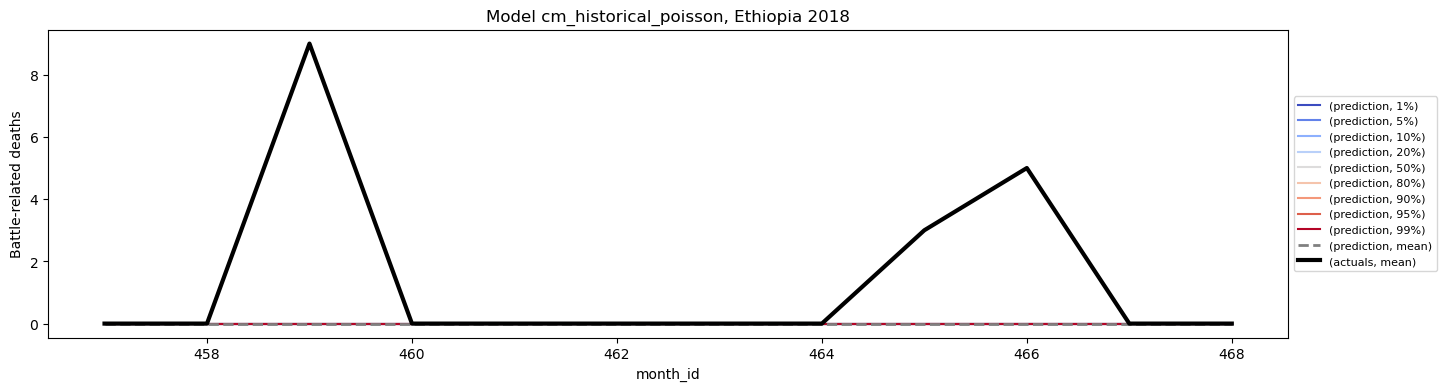

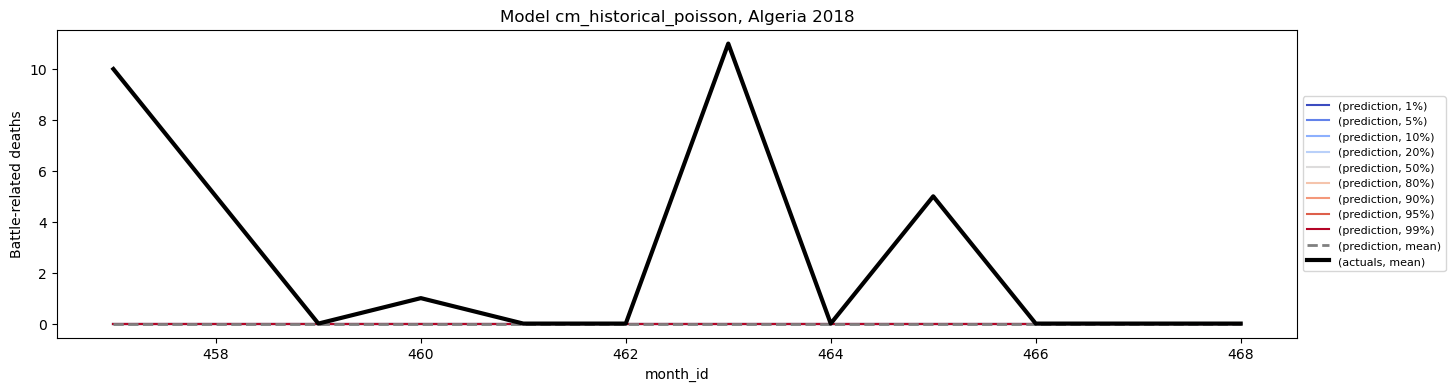

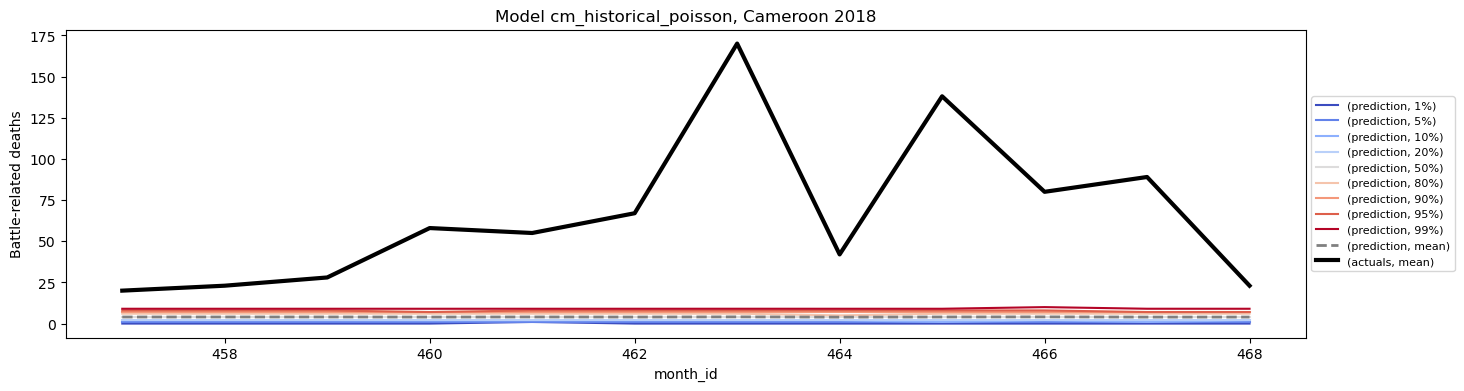

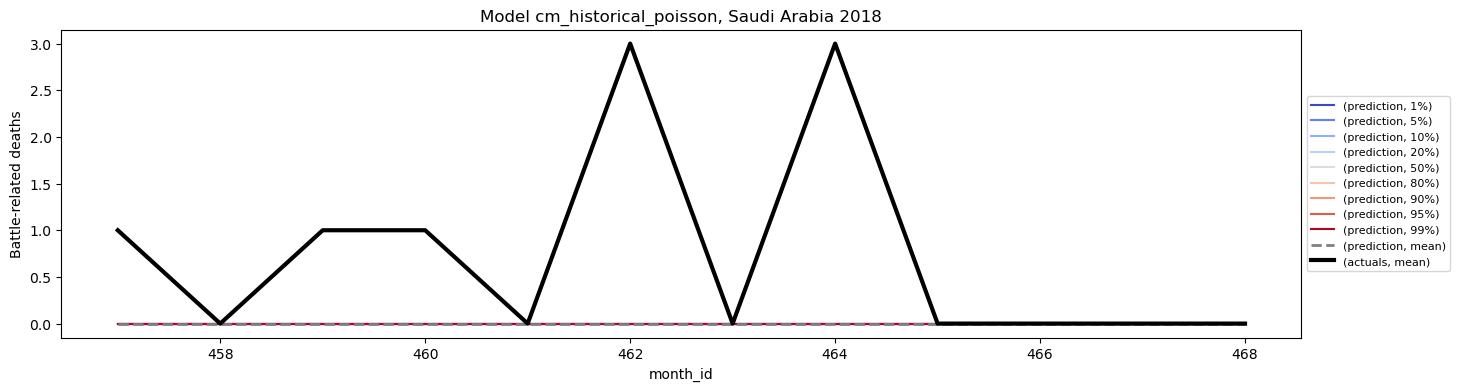

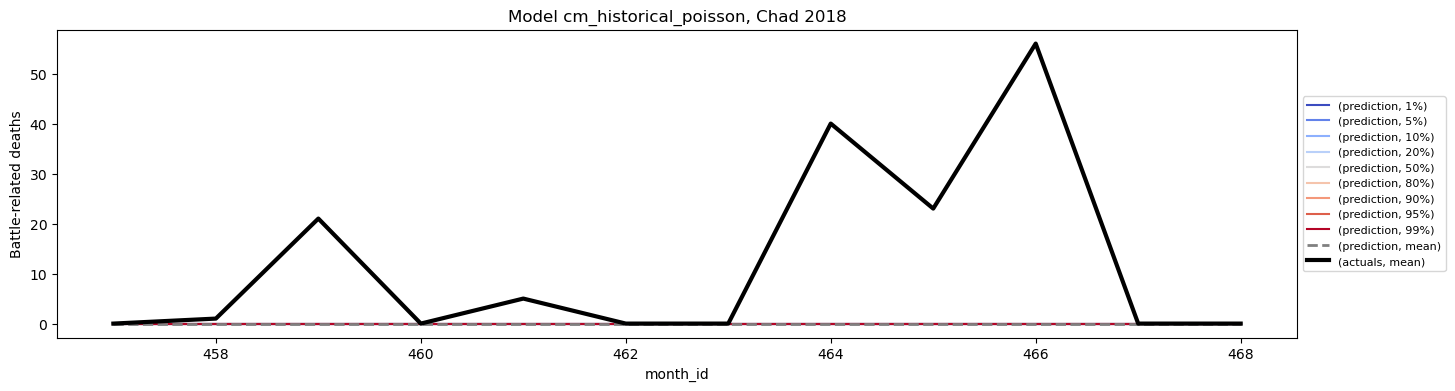

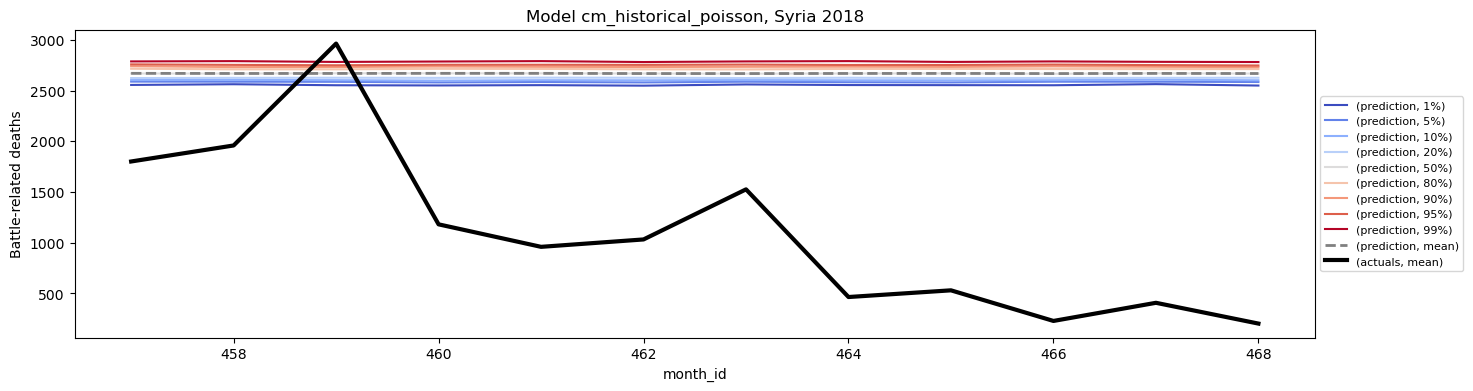

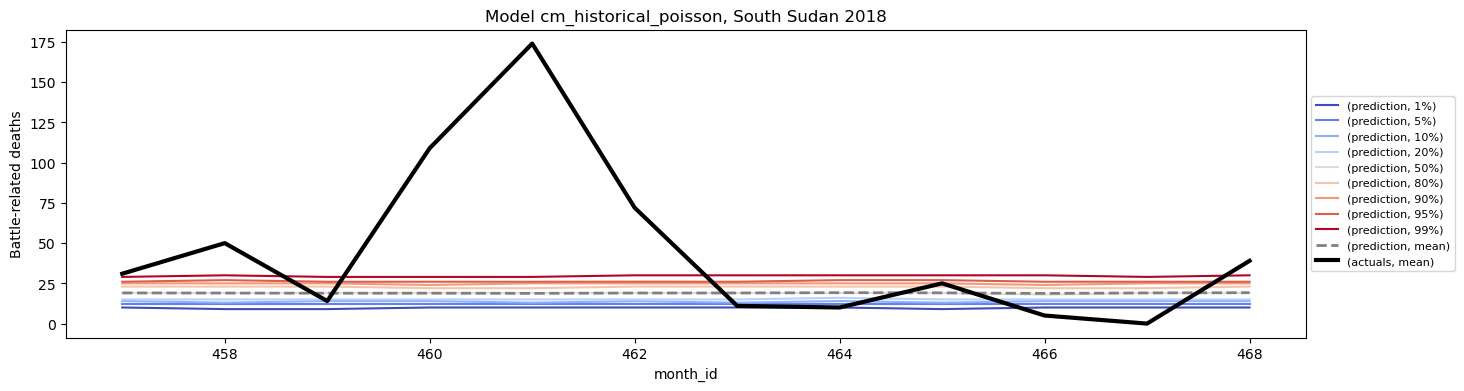

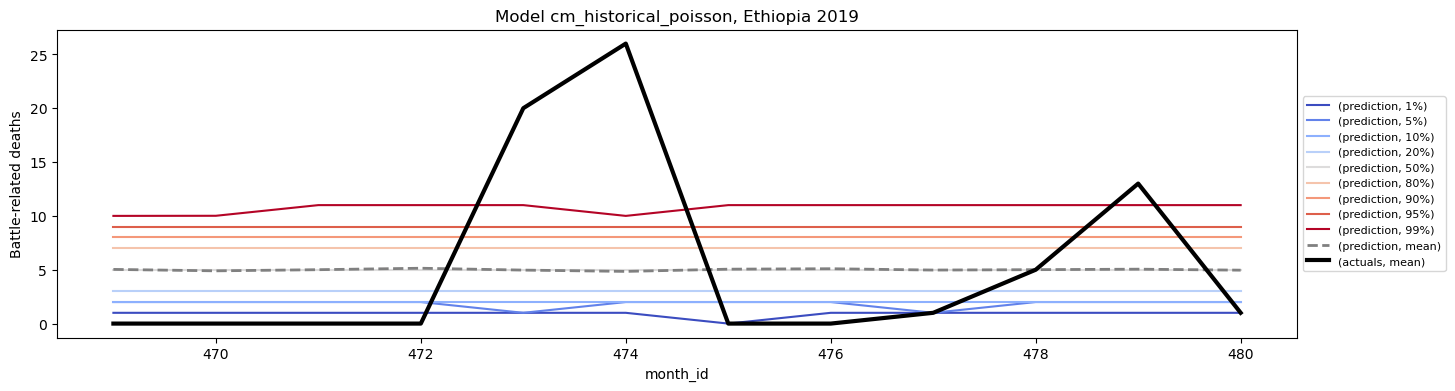

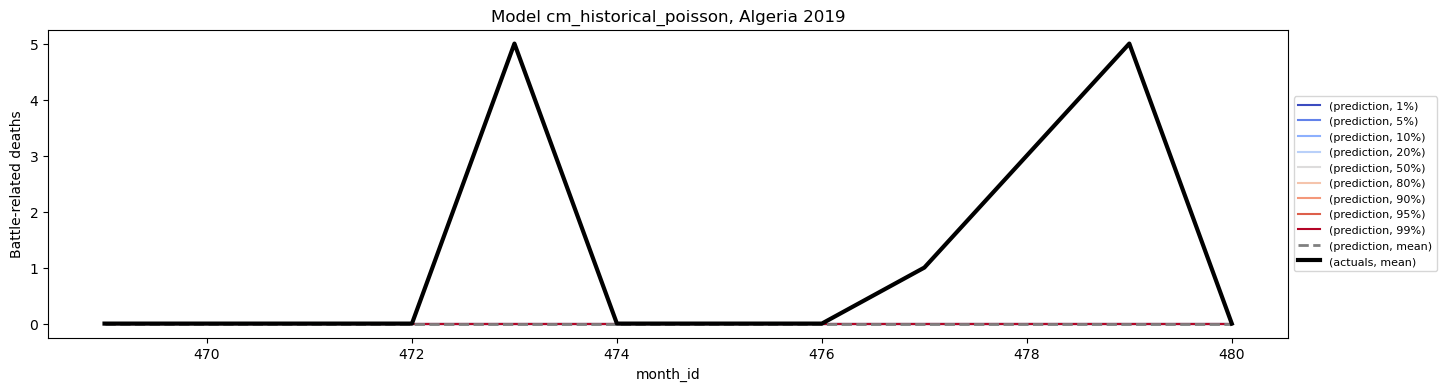

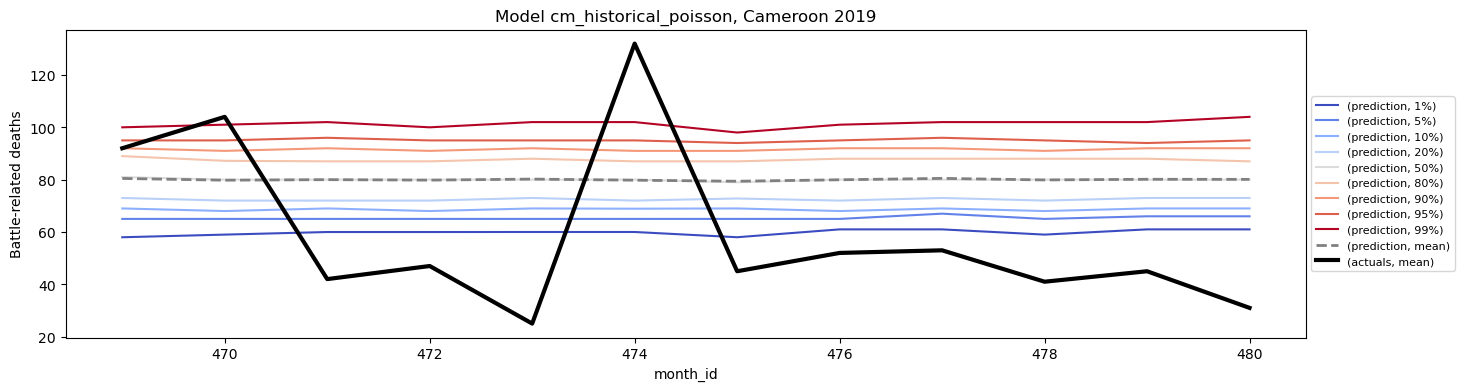

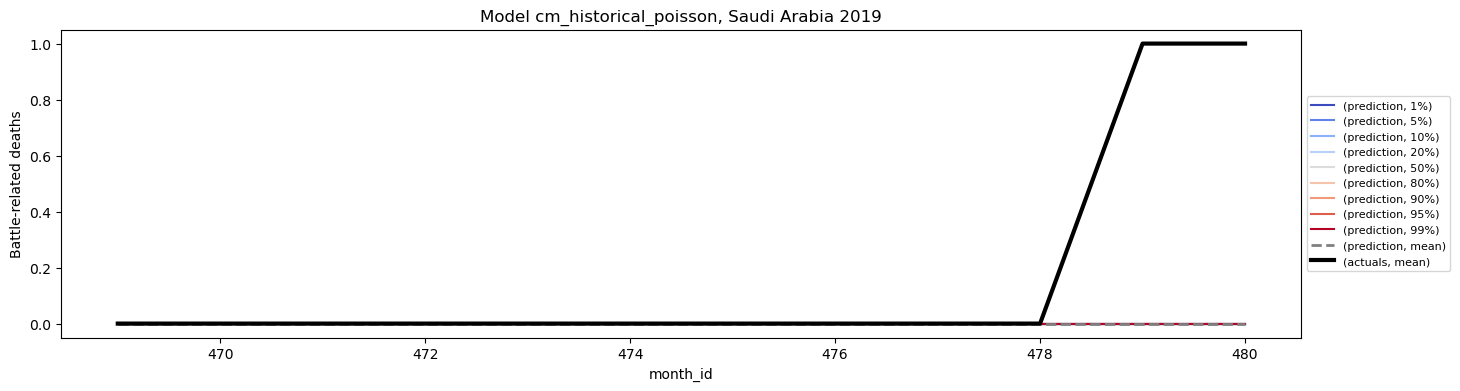

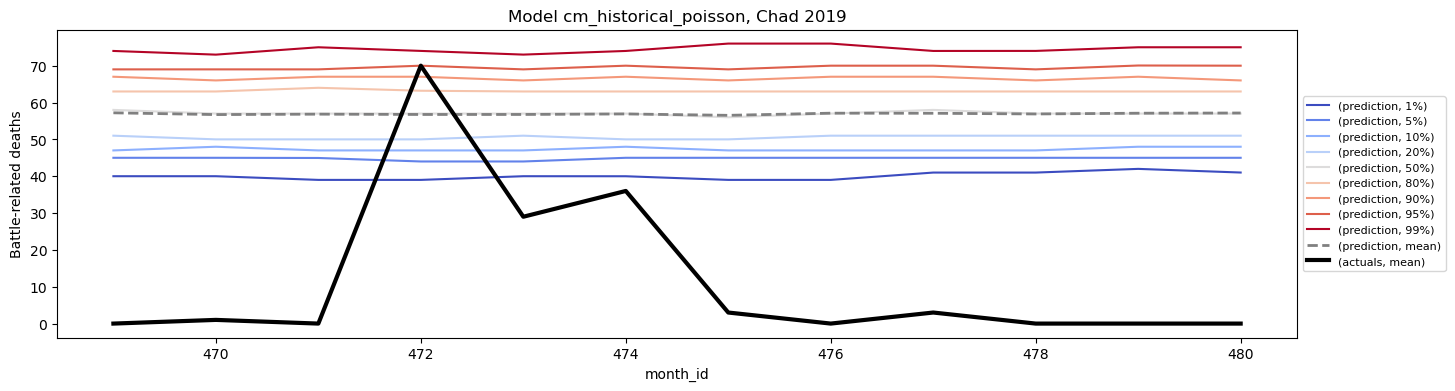

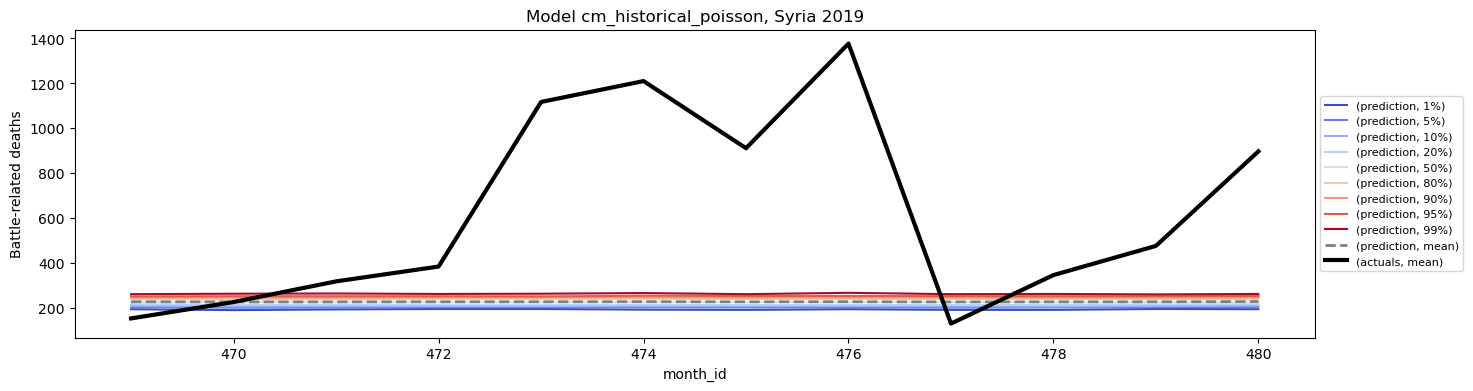

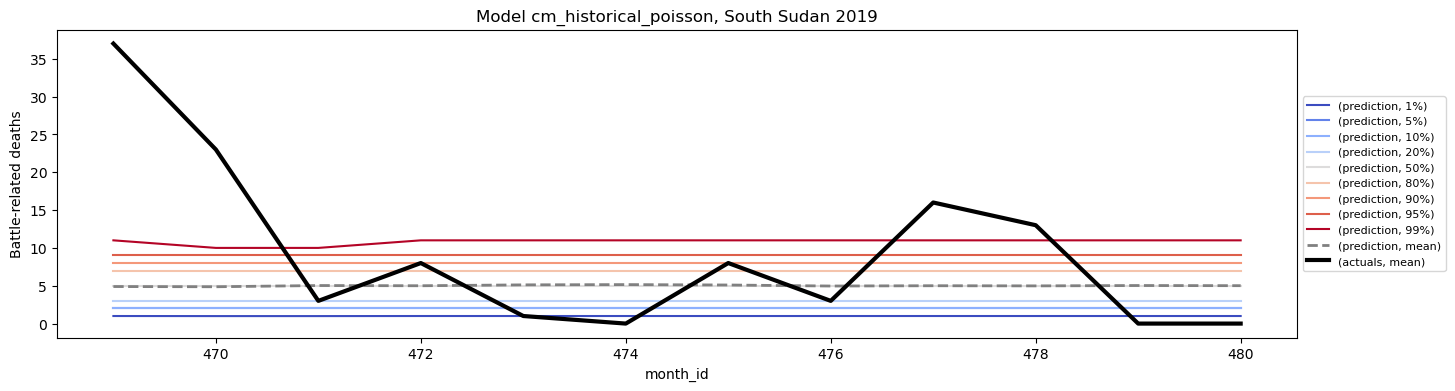

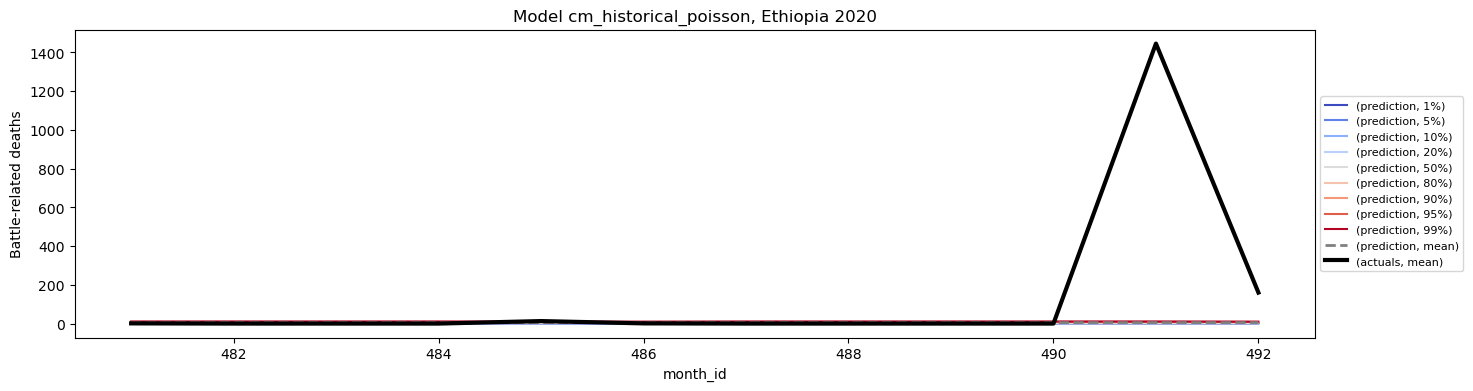

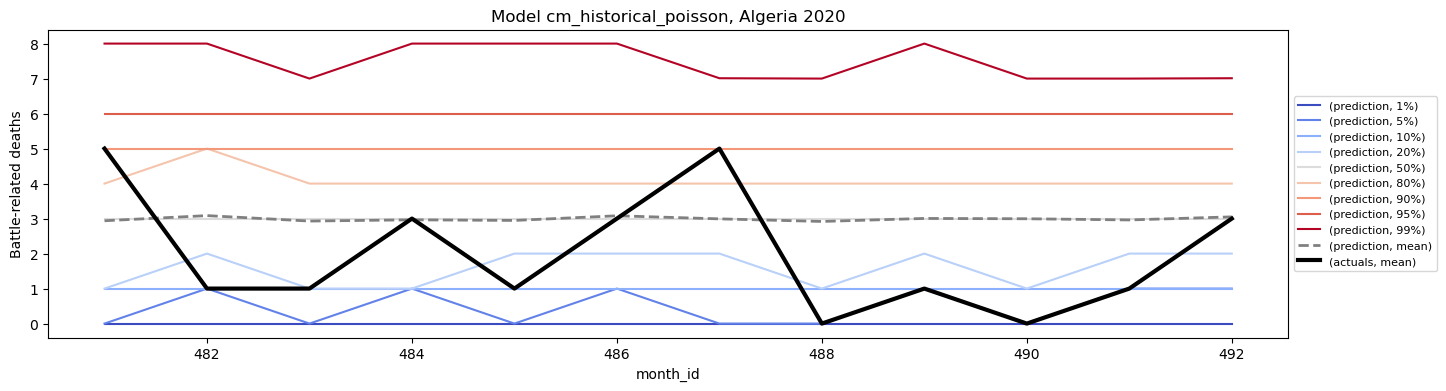

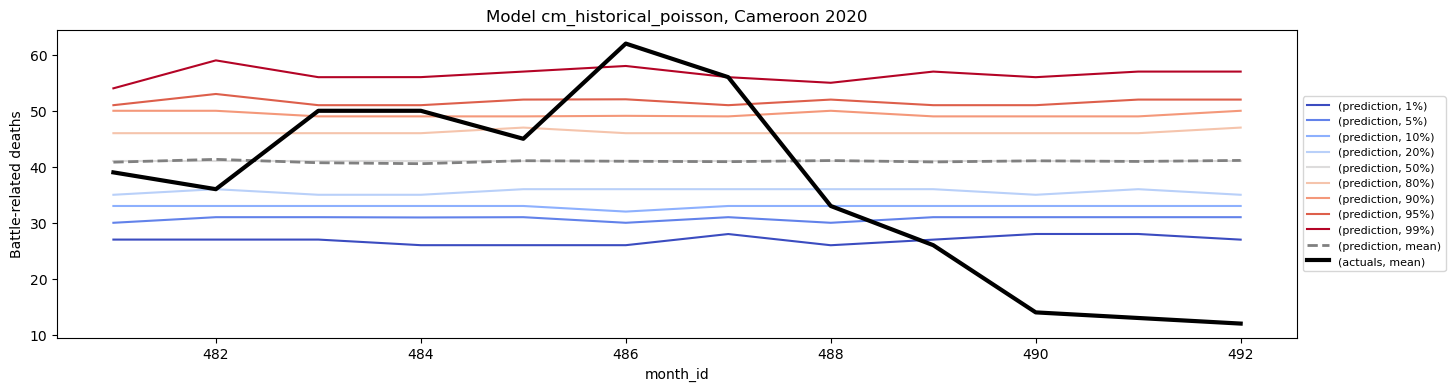

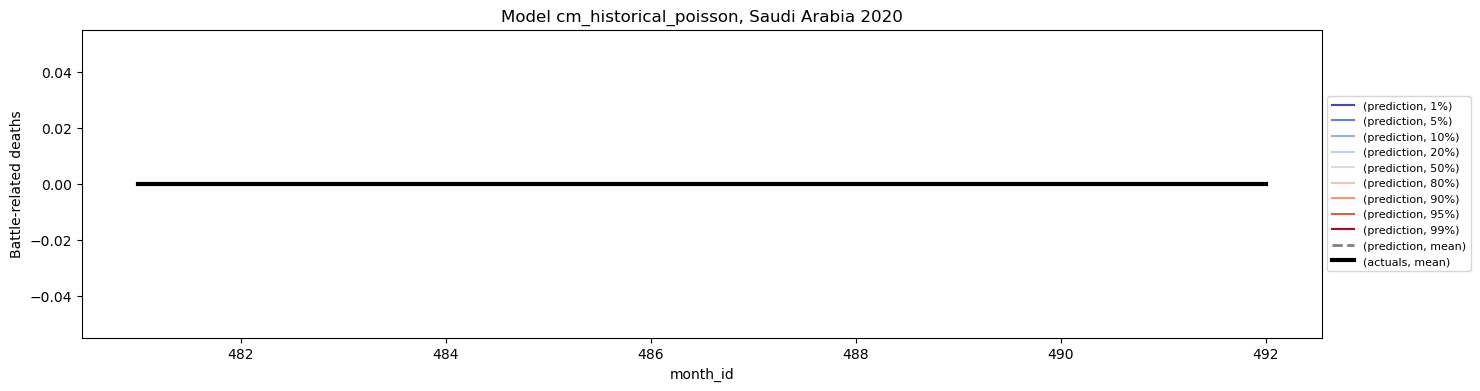

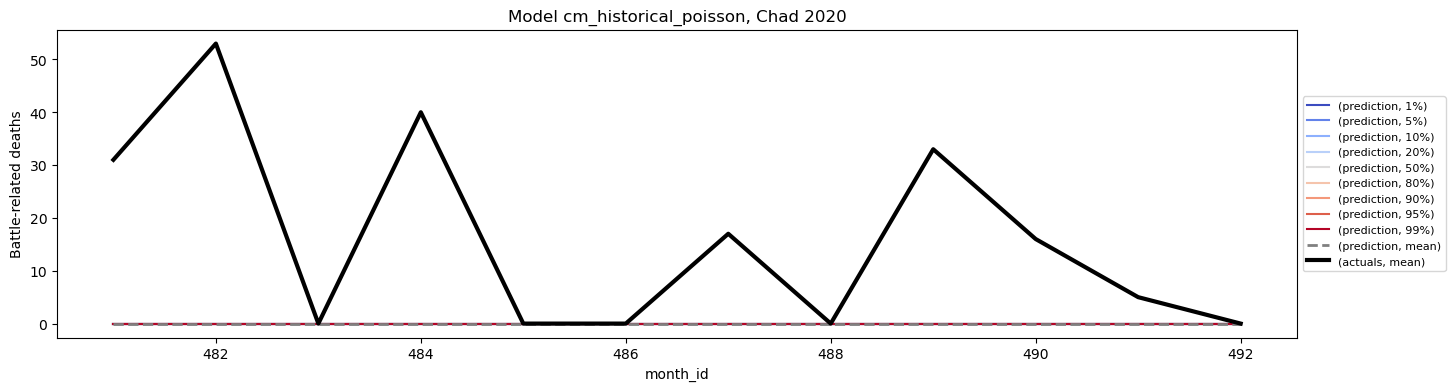

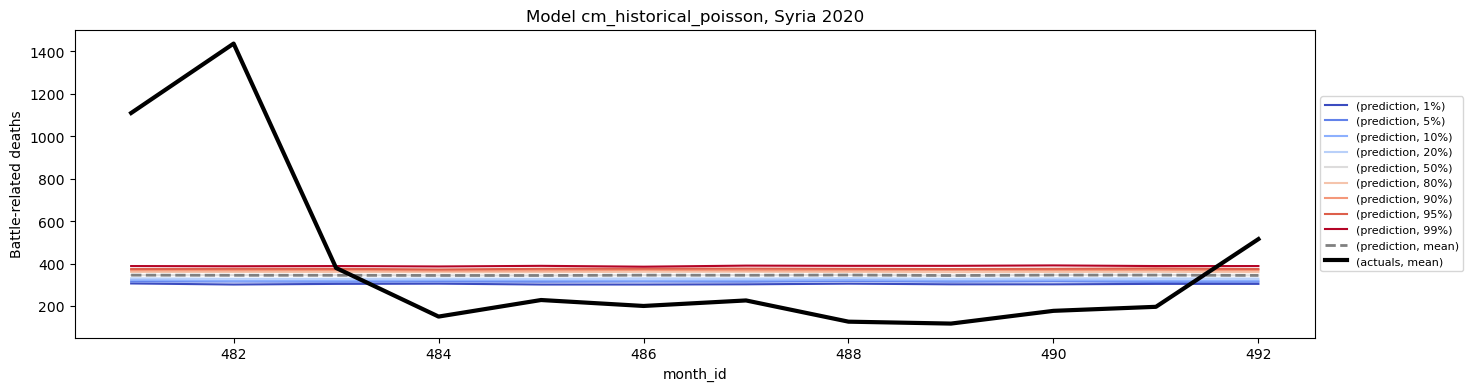

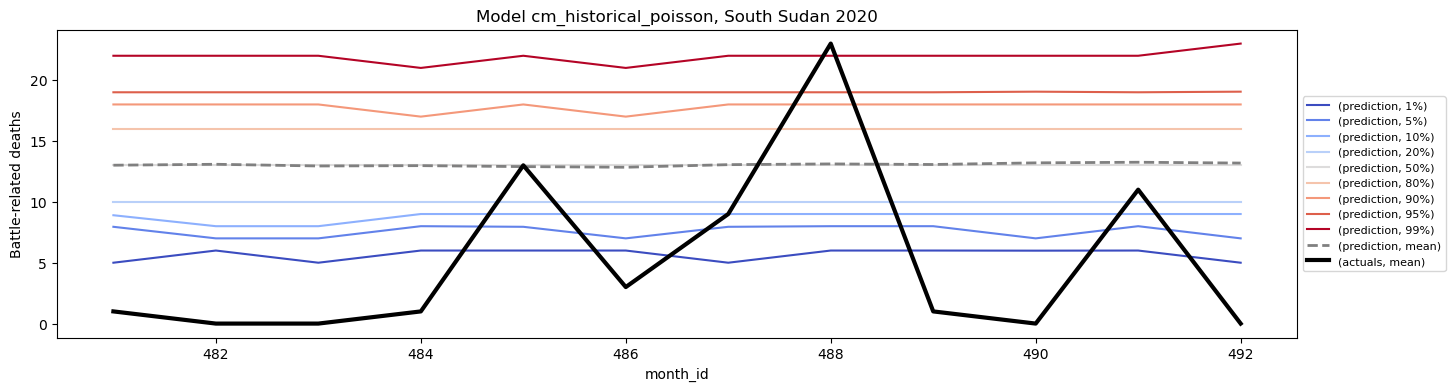

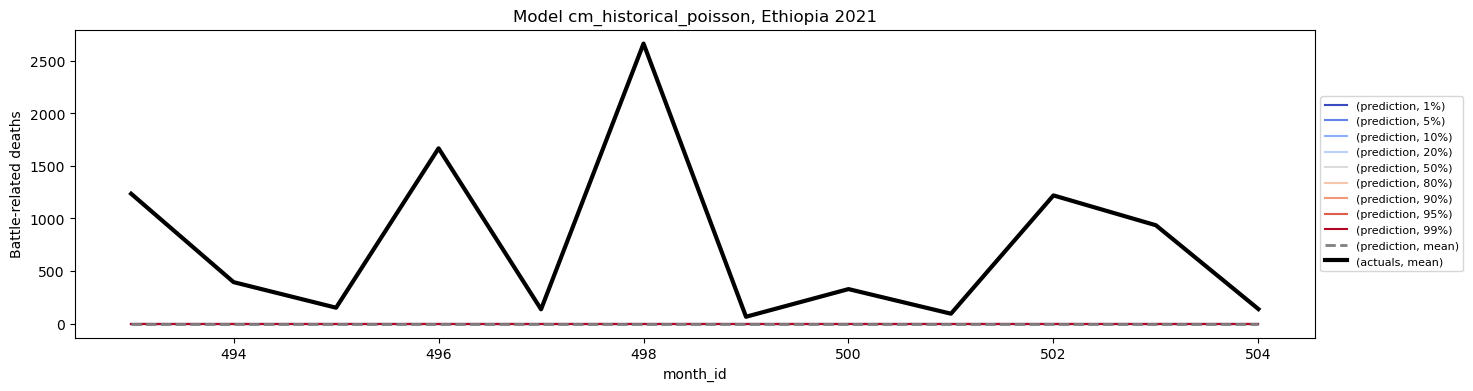

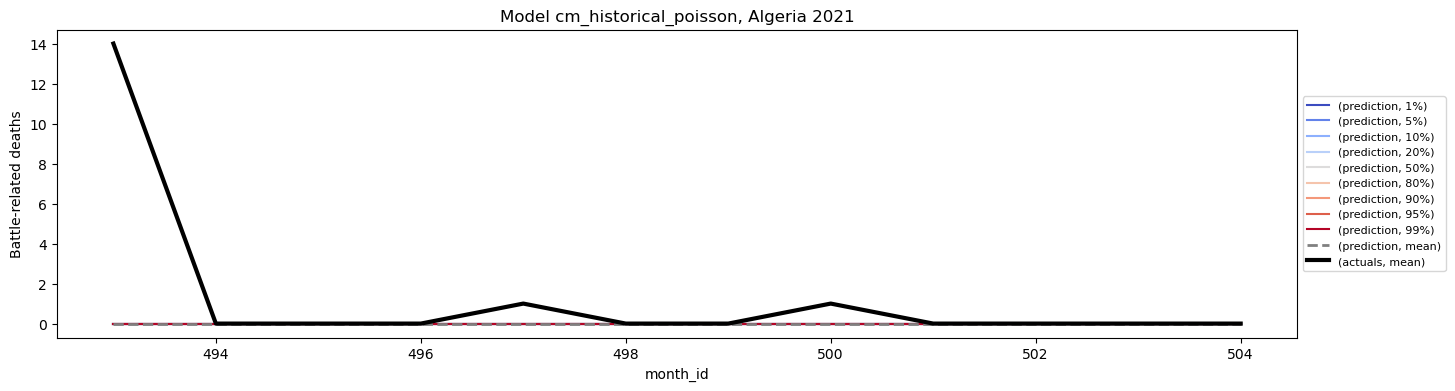

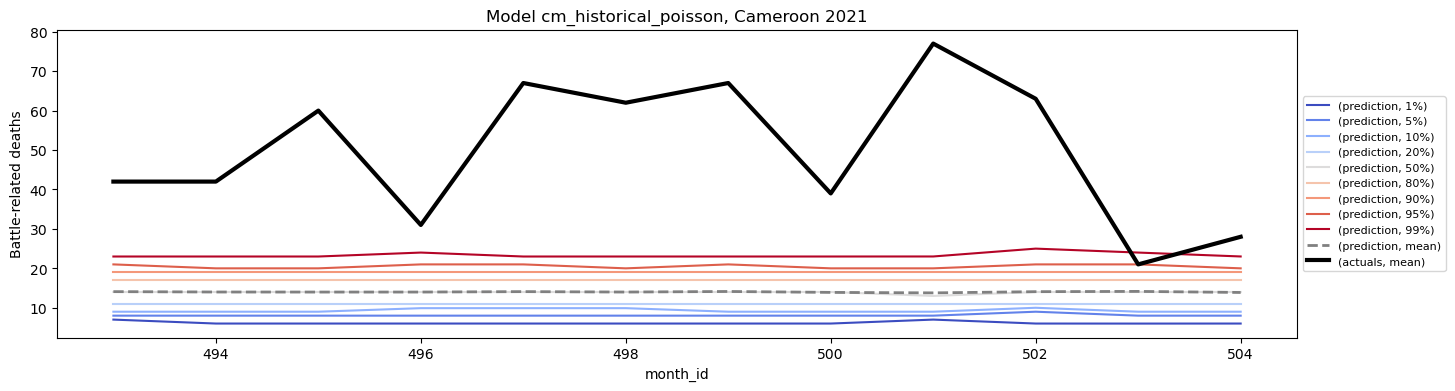

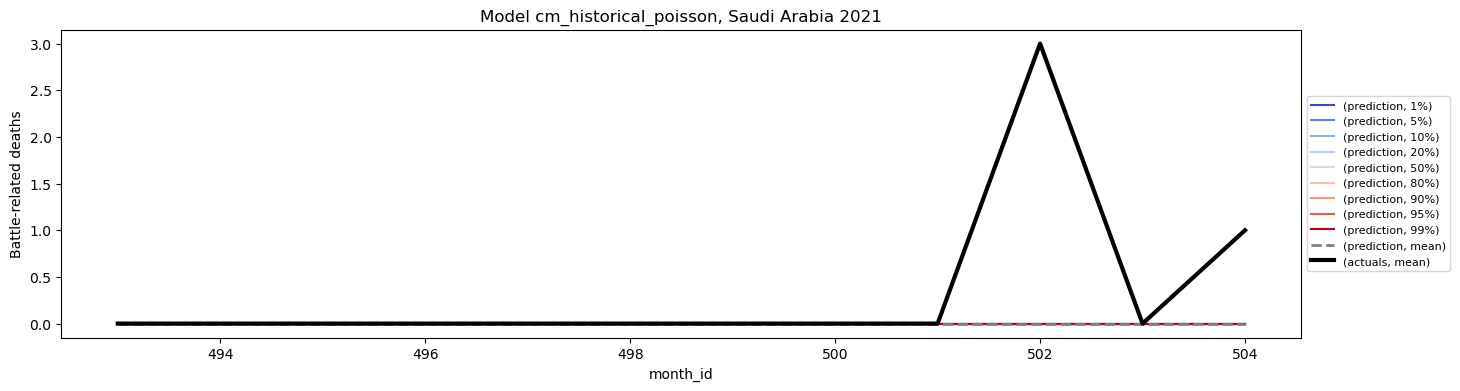

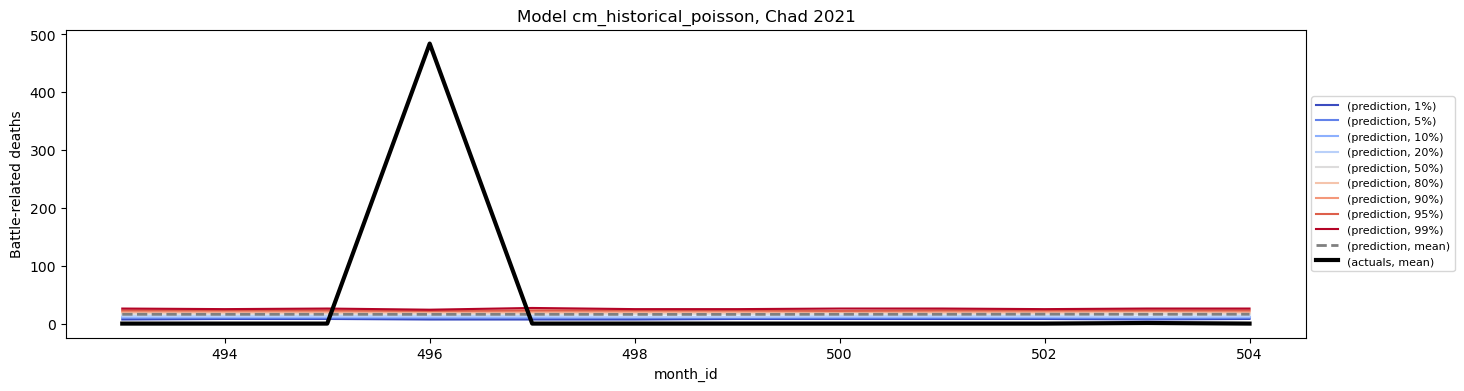

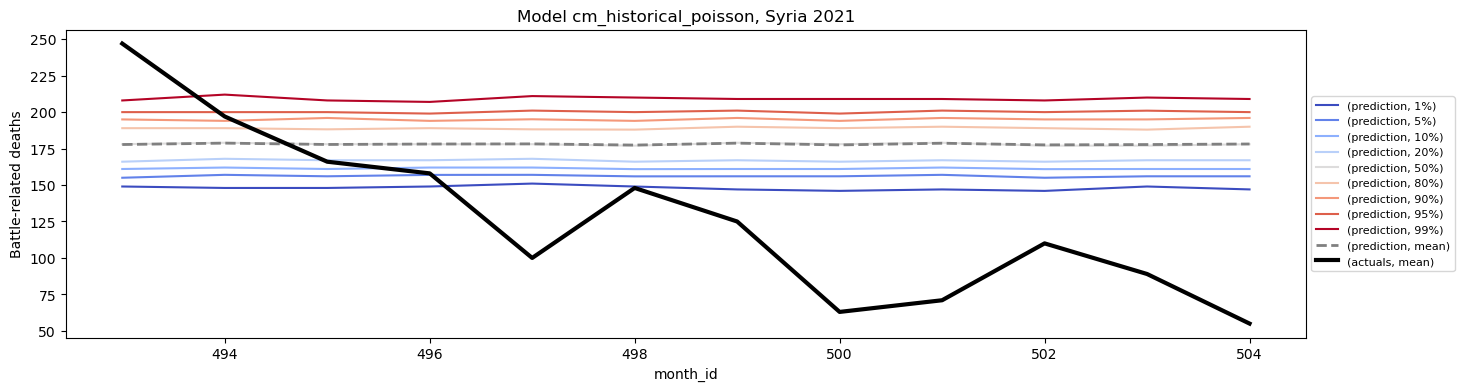

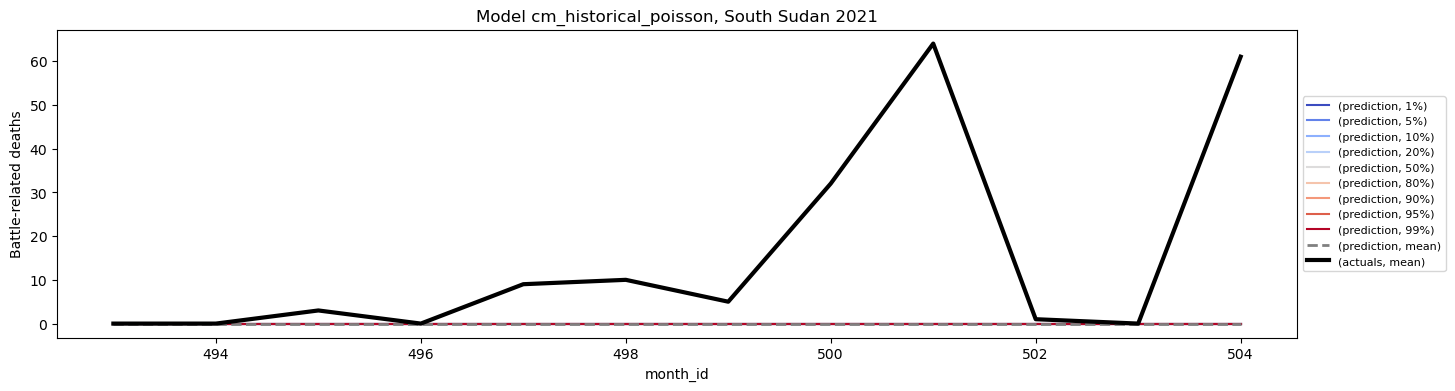

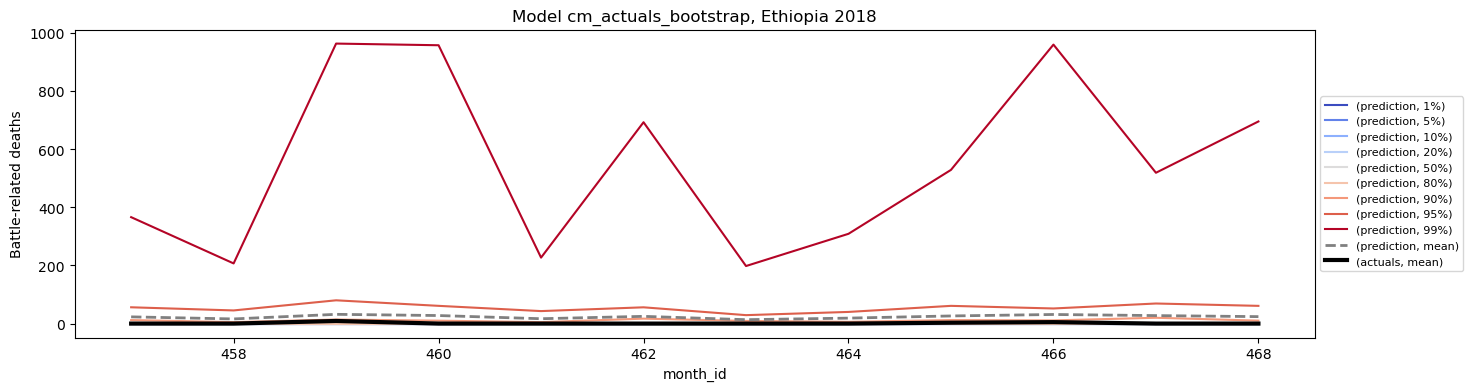

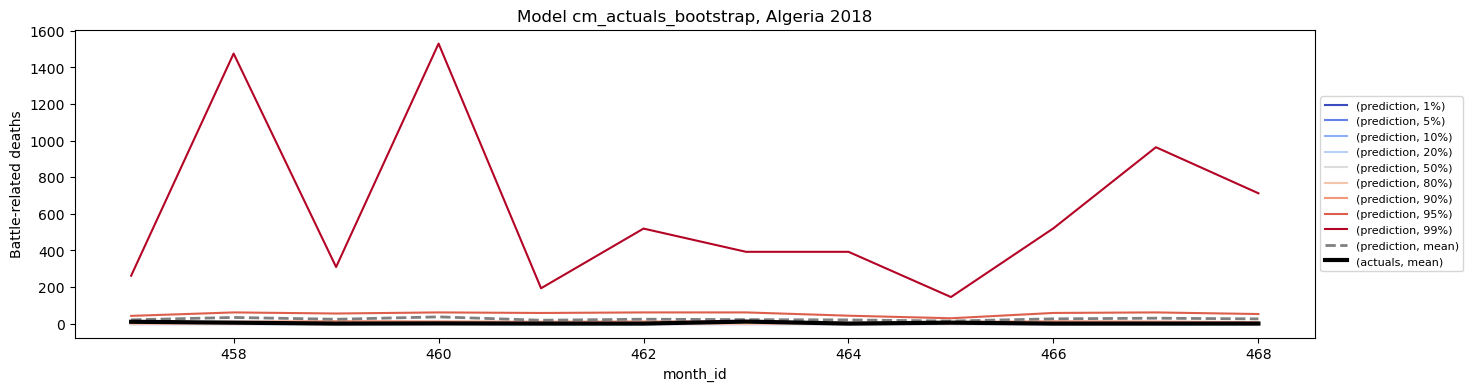

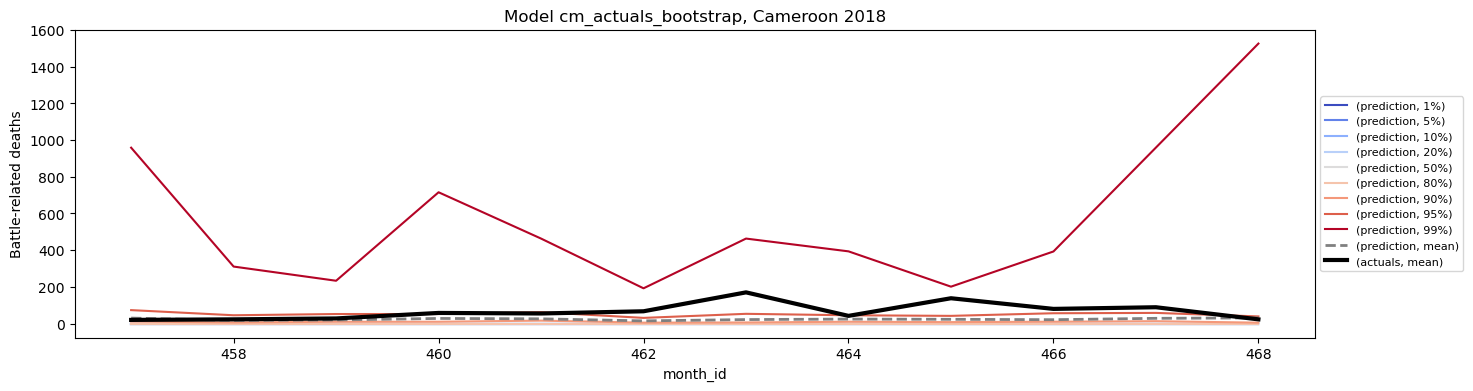

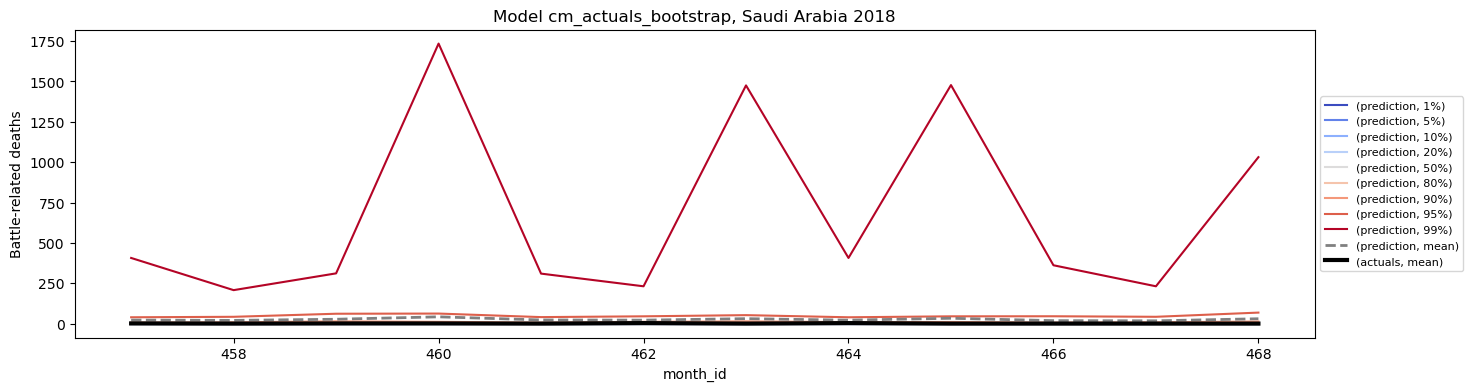

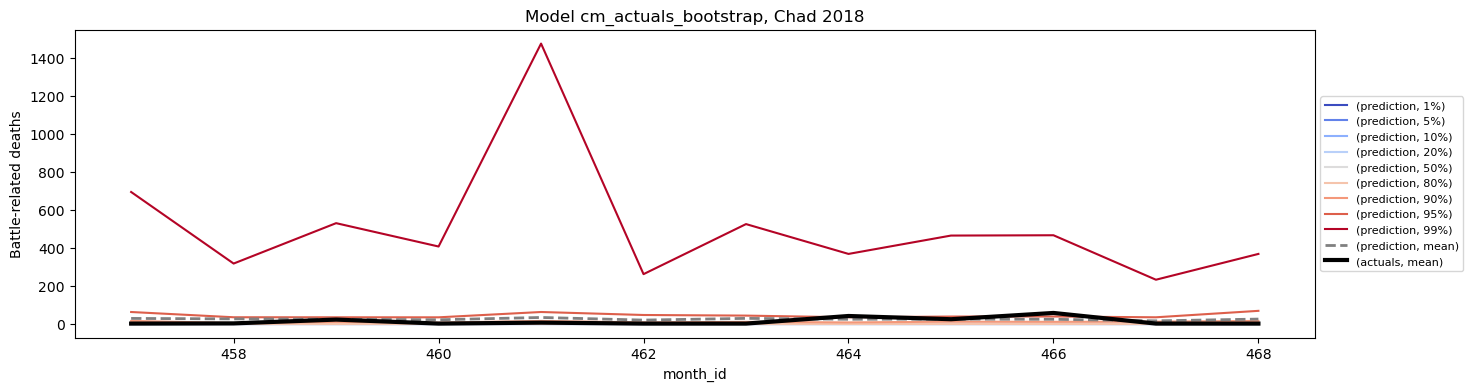

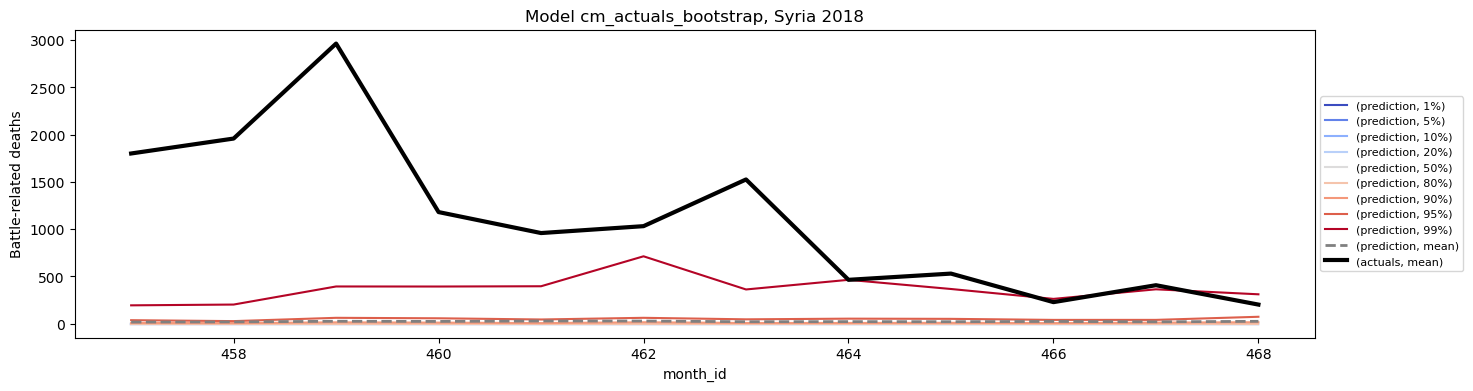

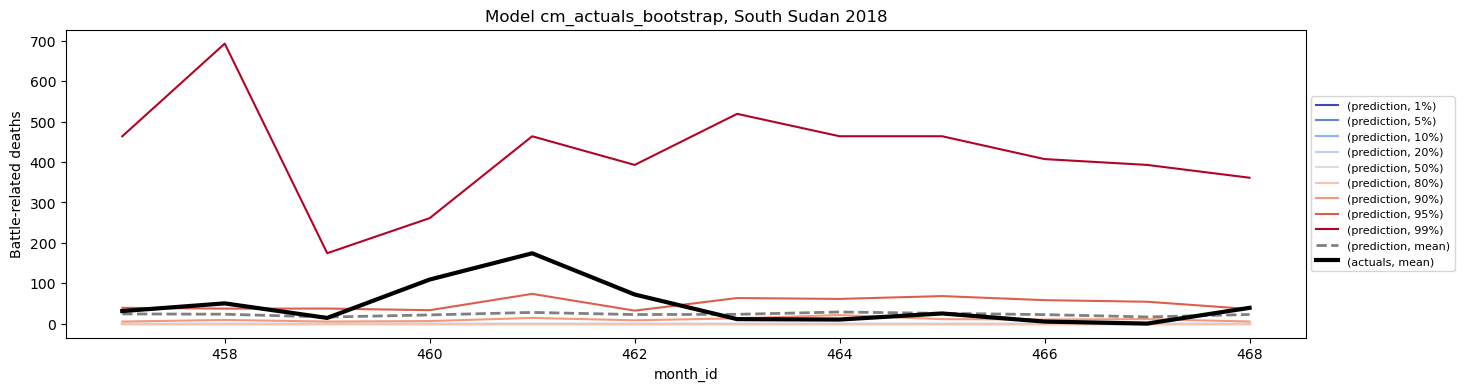

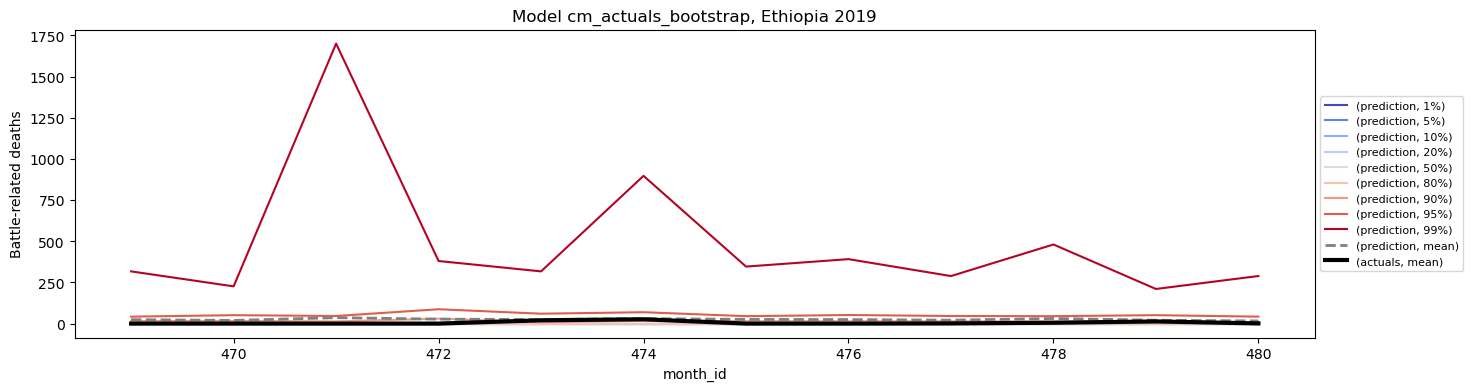

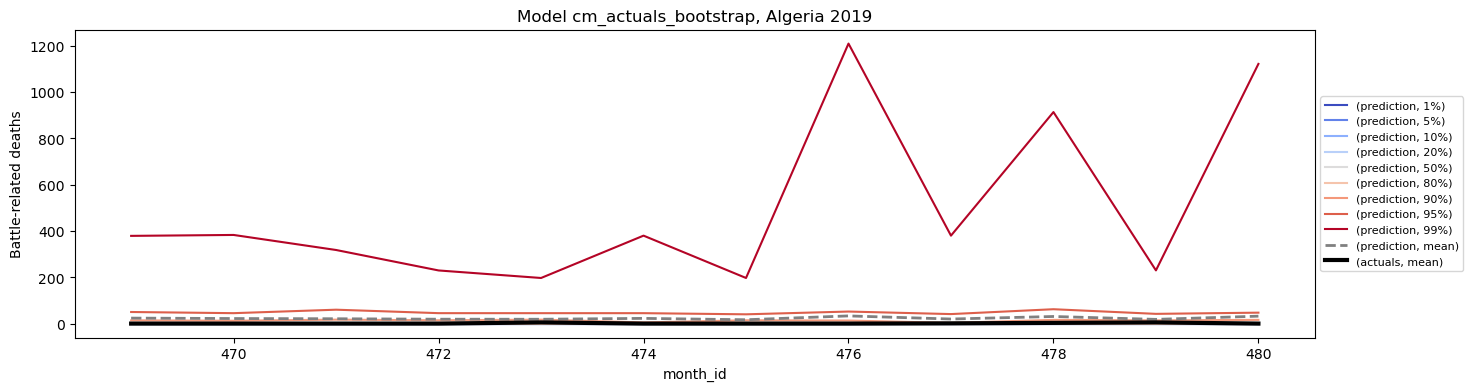

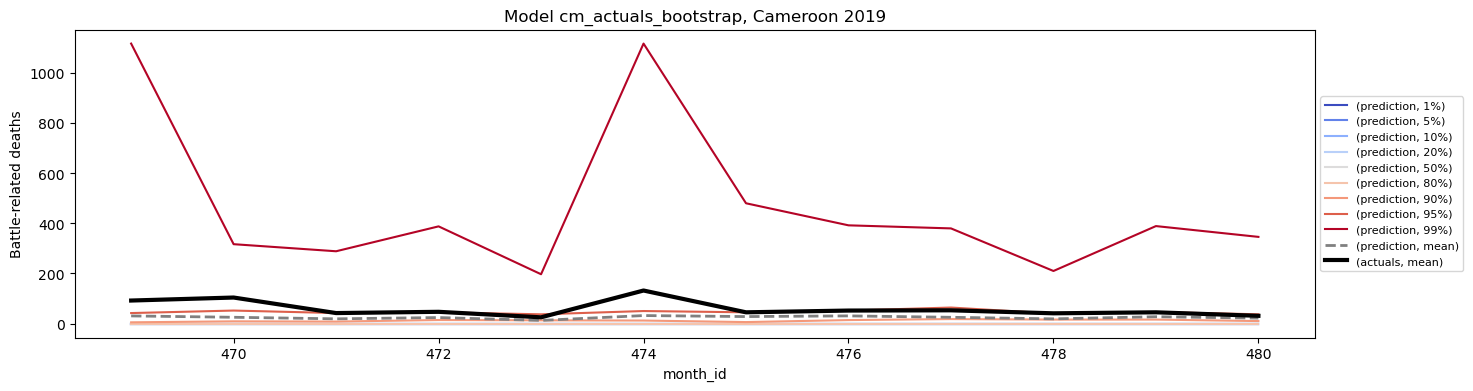

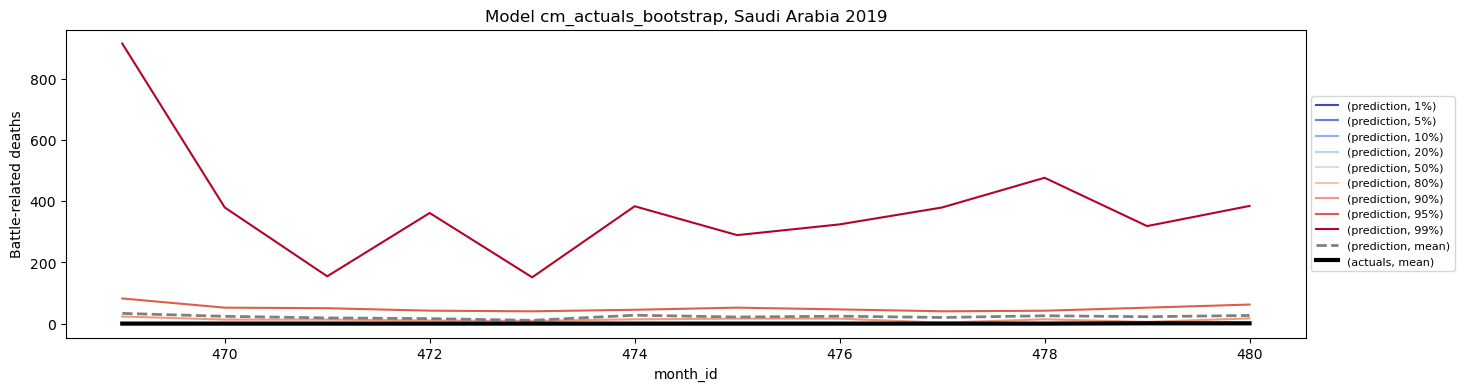

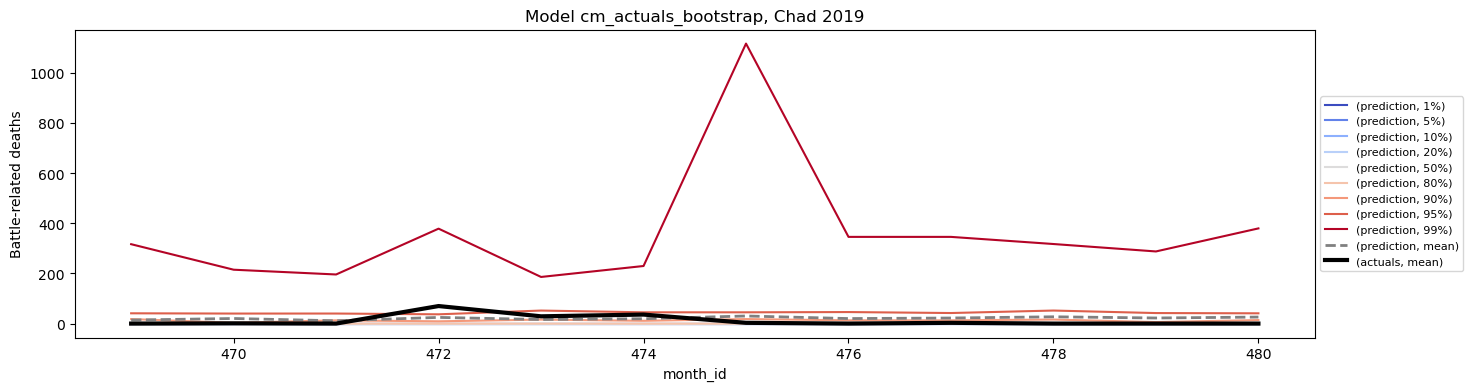

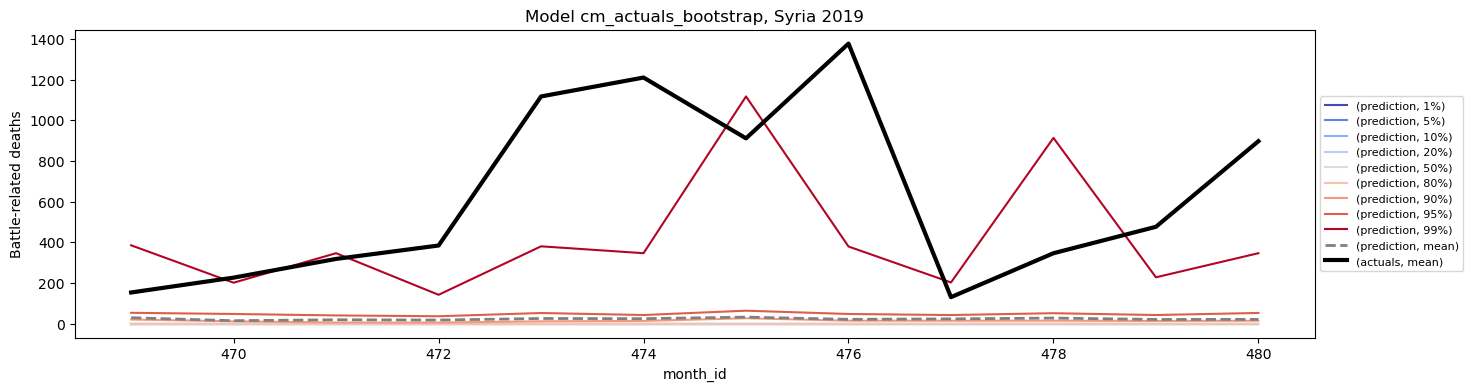

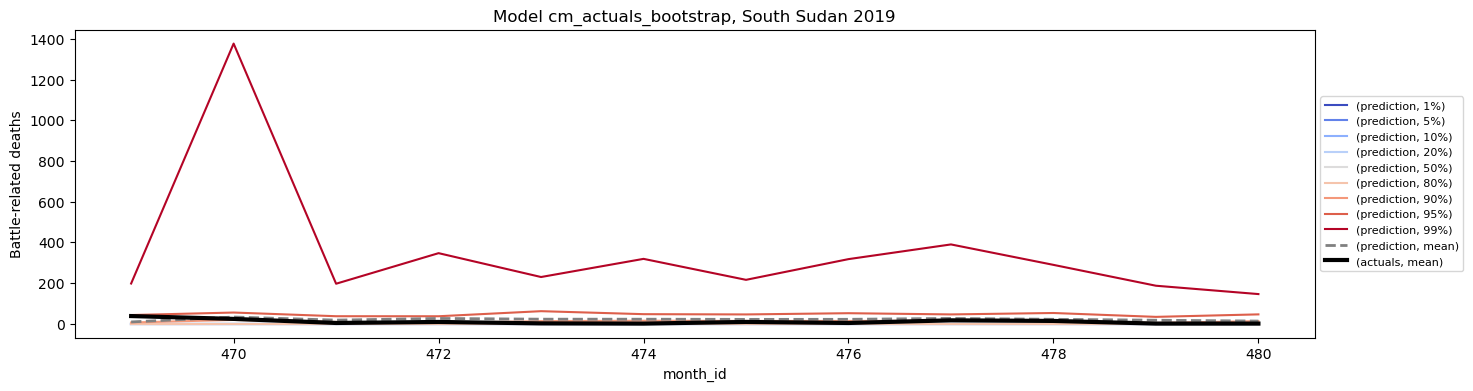

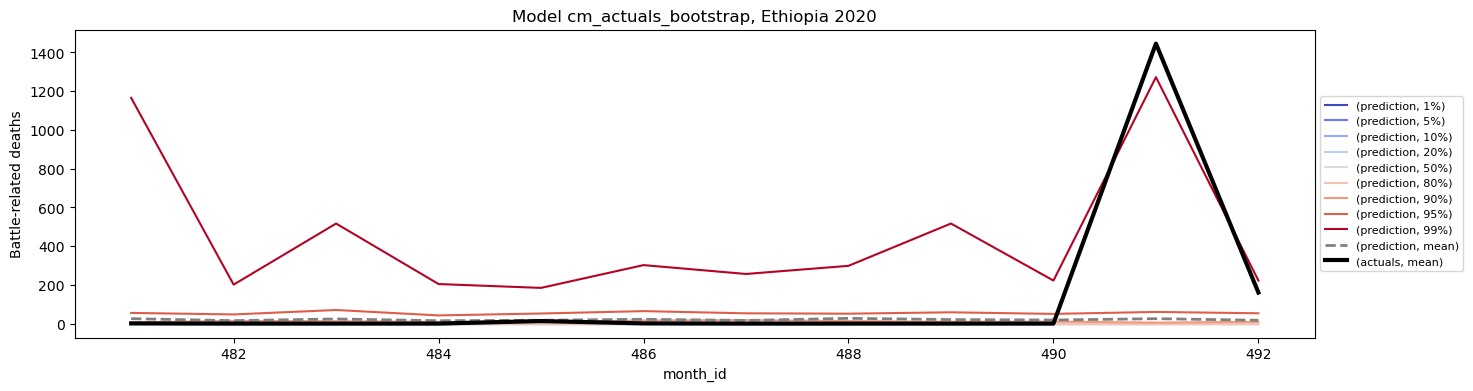

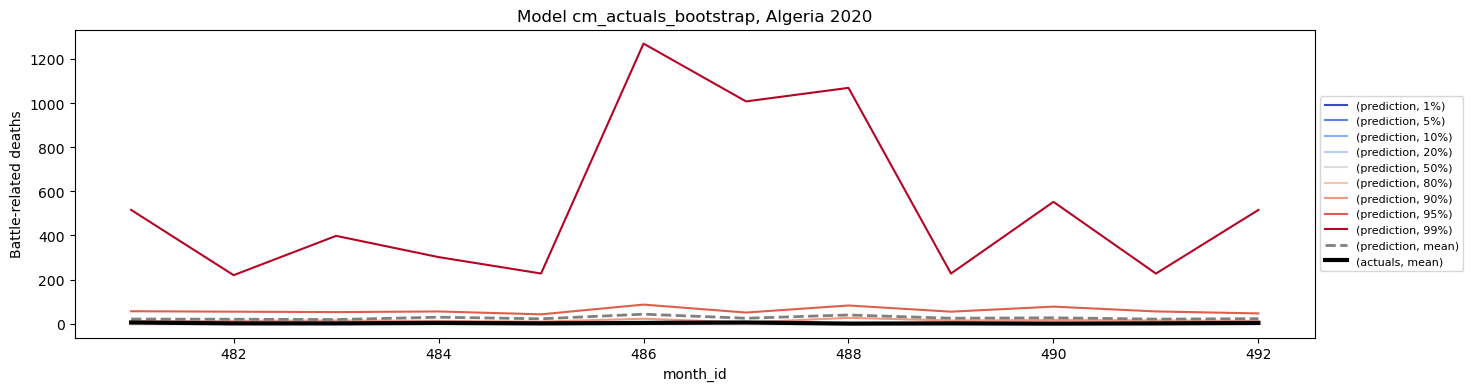

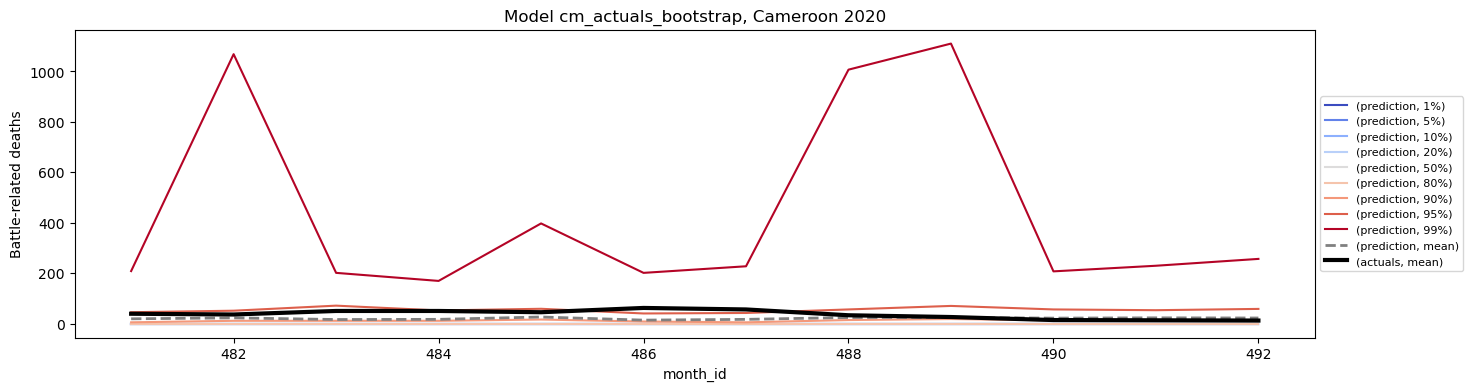

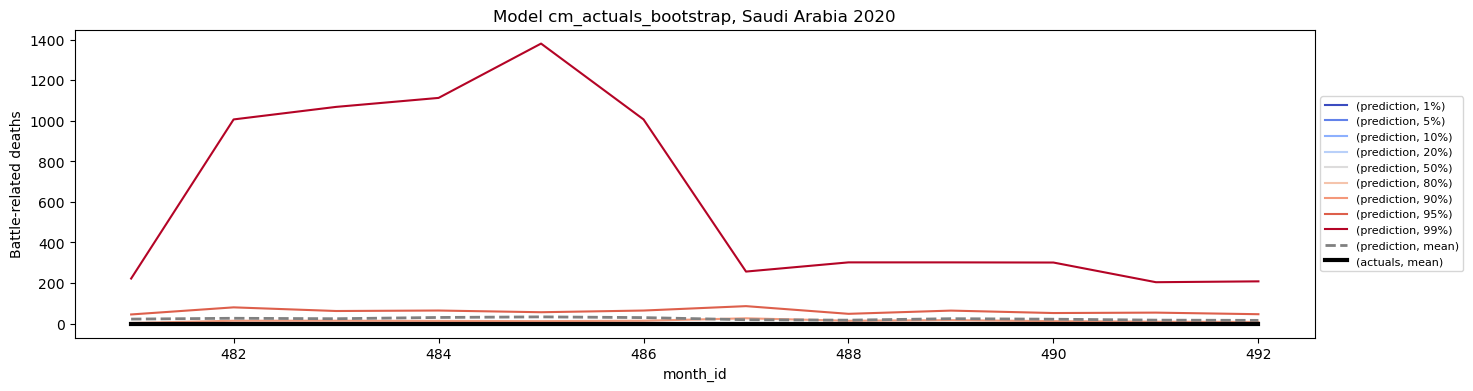

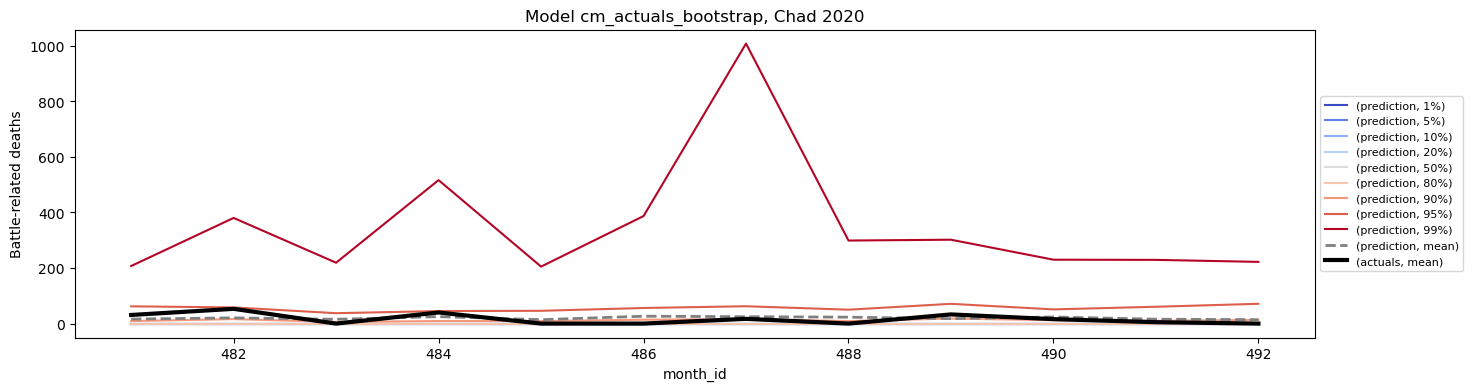

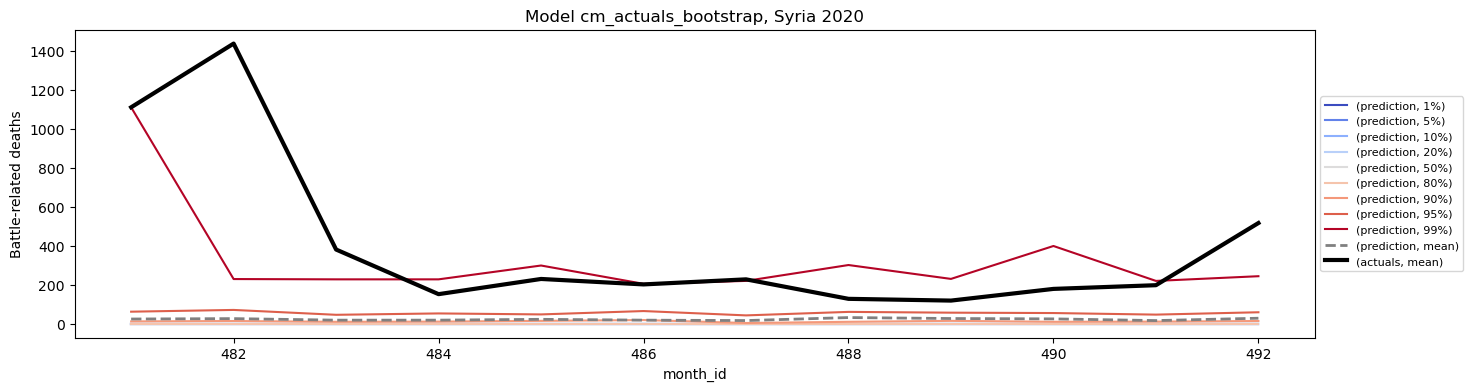

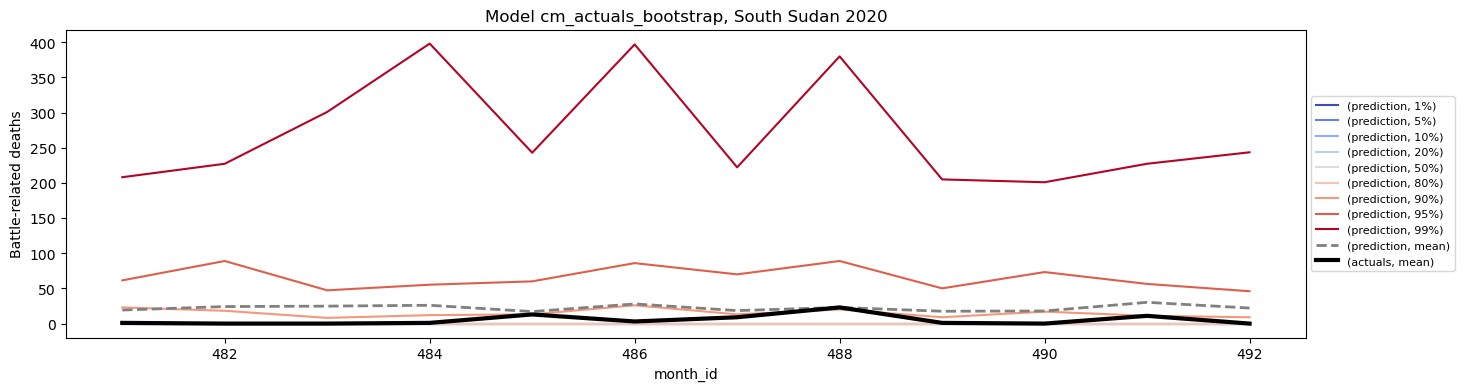

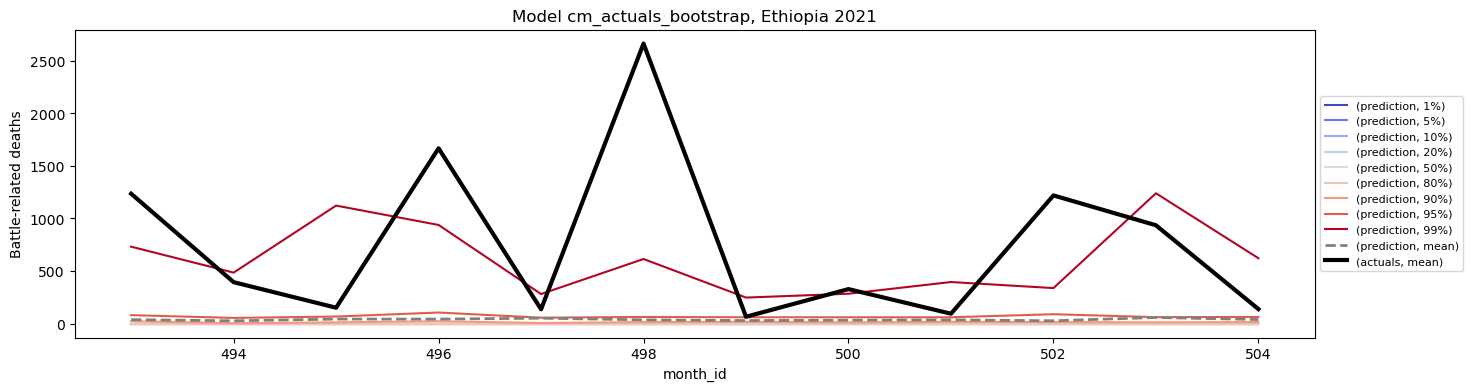

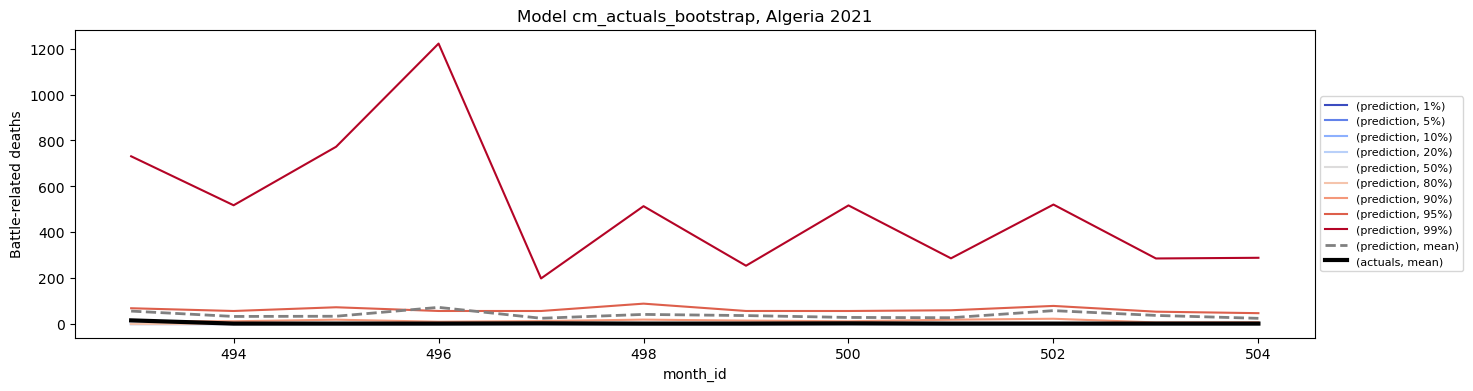

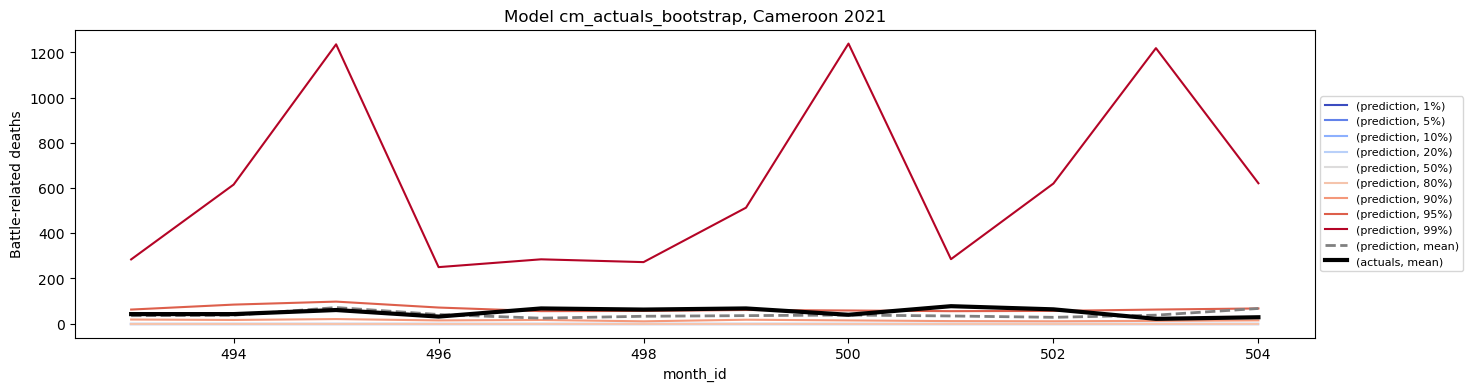

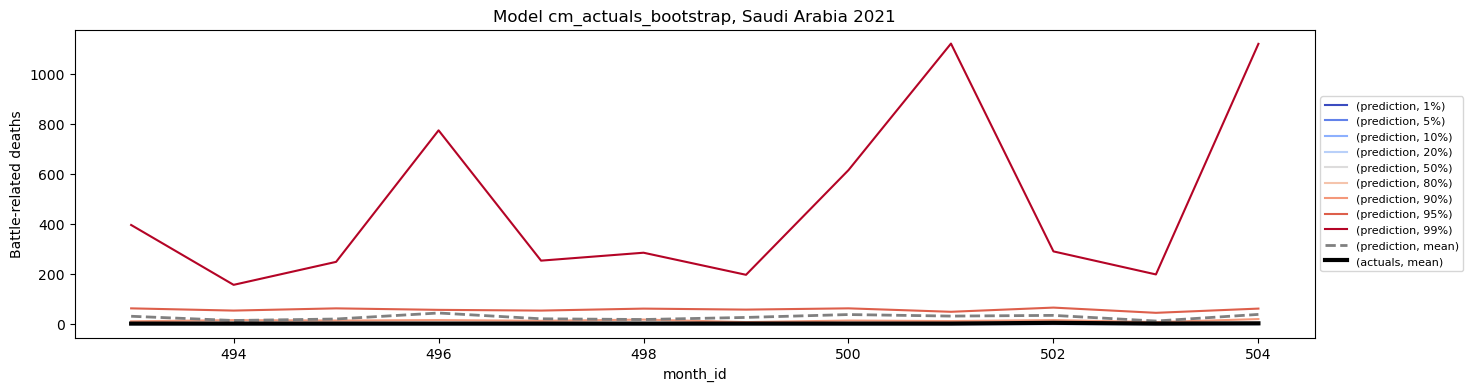

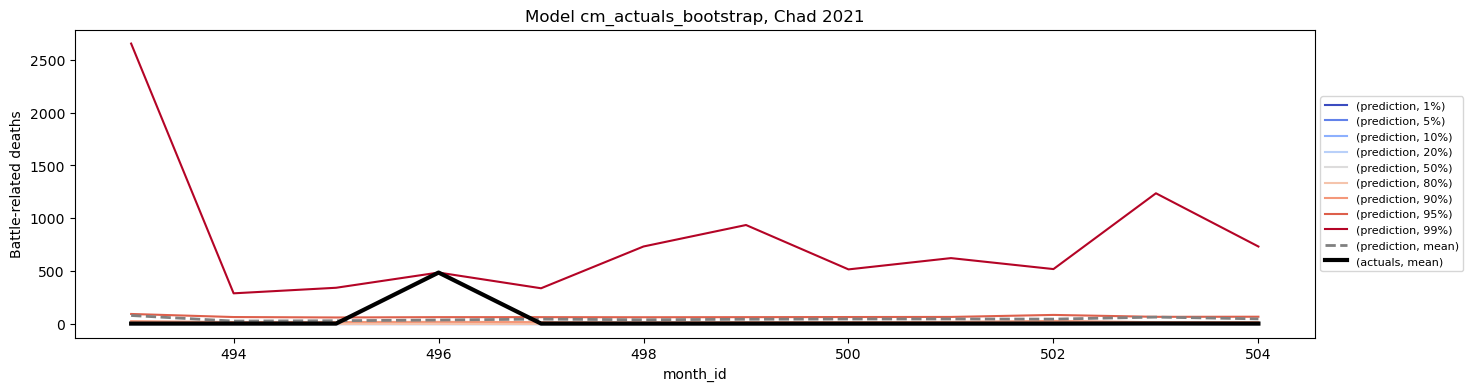

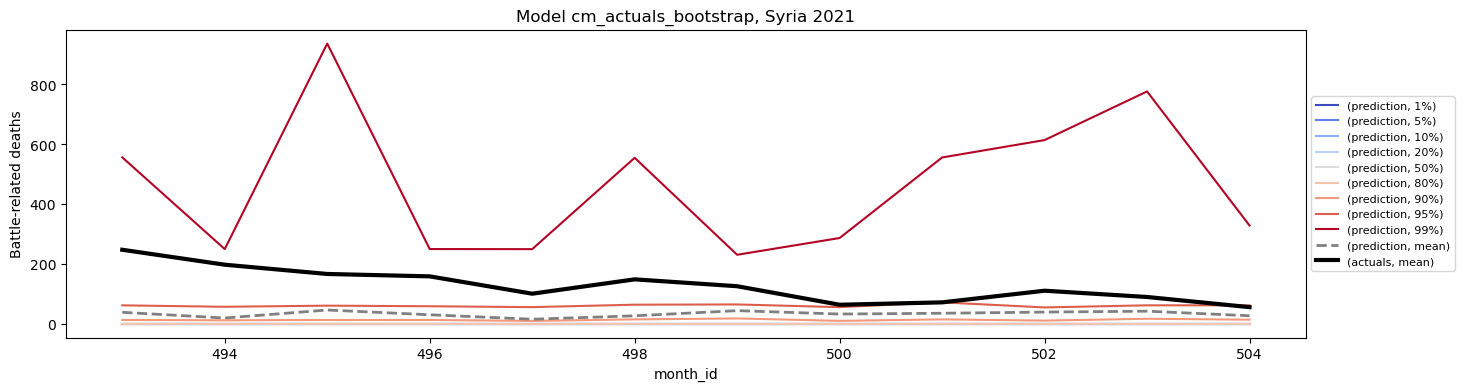

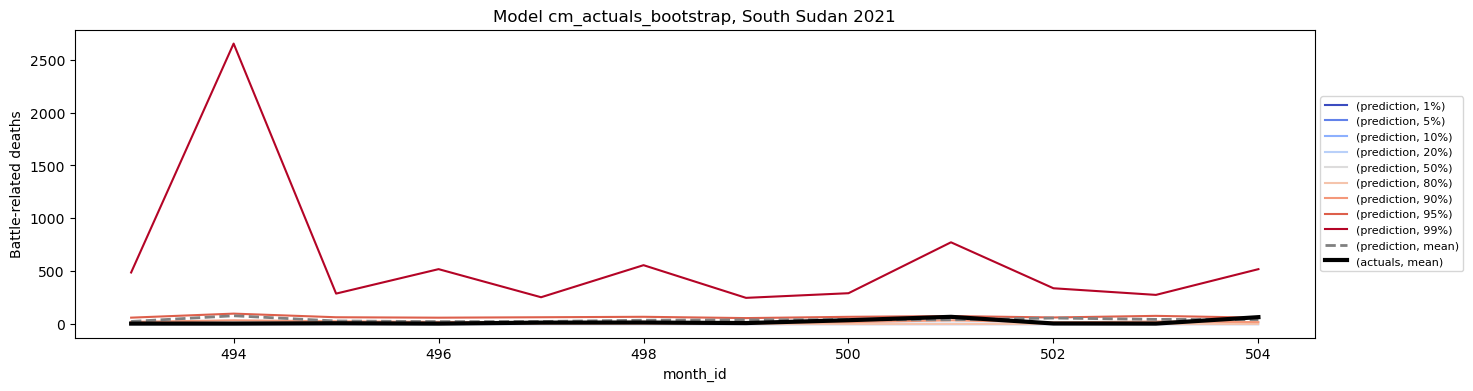

In [10]:

columns_to_plot = [
    ('prediction',    '1%'),
    ('prediction',    '5%'),
    ('prediction',   '10%'),
    ('prediction',   '20%'),
    ('prediction',   '50%'),
    ('prediction',   '80%'),
    ('prediction',   '90%'),
    ('prediction',   '95%'),
    ('prediction',   '99%'),
]
ctp1 = [
    ('prediction',  'mean'),]
ctp2 = [(   'actuals',  'mean')] # Separate set for separate color/pattern


for model_list in bm_list:
    for item in model_list:
        if item['level'] == 'cm':
            df_actuals = item['actuals'].reorder_levels(['country_id','month_id'])
            df_actuals.rename(columns={'outcome':'actuals'},inplace=True)
            df_full = item['df_full'].reorder_levels(['country_id','month_id','draw'])
            df_full.rename(columns={'outcome':'prediction'},inplace=True)
            df_merged = pd.merge(df_actuals, df_full,left_index=True,right_index=True)
            for c in [57,67,69,131,214,220,246]:
                countryname = countrylist.loc[c]['name']
                title = 'Model ' + item['name'] + ', ' + countryname + ' ' + str(item['year'])
                fig, axs = plt.subplots(figsize=(16, 4))
                df_description = df_merged.loc[c].groupby('month_id').describe(percentiles=[.01,.05,.1,.2,.5,.8,.9,.95,.99])
                df_description[columns_to_plot].plot(use_index=True,ylabel='Battle-related deaths',ax=axs,title=title,colormap='coolwarm')
                df_description[ctp1].plot(ax=axs,color='gray',  linestyle='dashed', linewidth=2)
                df_description[ctp2].plot(ax=axs,color='black', linewidth=3)
                axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':8})
                fig.savefig(overleafpath_figures+'bm_predictions/'+'predictions_and_actuals_' + countryname + '_' + str(item['year']) + '_' + item['name'])


# Assembling evaluation tables


In [11]:
# Create table A for each model with:
# one row for each year plus one for mean over years
# one col for crps 
# one col for ign 
# one col for mis
# Create table B with the same, but metrics per month

# Table A:
for model_list in bm_list:
    year_list = []
    for item in model_list:
        metrics = pd.concat([item['crps'],item['ign'],item['mis']],axis=1)
        metrics['year'] = item['year']
        year_list.append(metrics)
    table_annual = pd.concat(year_list,axis=0)   
    table_annual.set_index(str('year'),inplace=True)
    table_annual.loc['Mean'] = table_annual.mean()
    table_filename = overleafpath + 'bm_evaluation/' + item['name'] + '_aggregated' + '.tex'
    print(item['name'],table_filename)
    with open(table_filename, 'w') as tf:
        tf.write(table_annual.to_latex(float_format="{:.2f}".format))

# Table B:
for model_list in bm_list:
    year_list = []
    for item in model_list:
        metrics = pd.concat([item['crps_by_month'],item['ign_by_month'],item['mis_by_month']],axis=1)
        metrics['month'] = metrics.index - (item['year']-1980)*12
        metrics['month'] = metrics['month'].astype(int)
        metrics['year'] = item['year']
        year_list.append(metrics)
    table_monthly = pd.concat(year_list,axis=0)   
    table_monthly.set_index(['year','month'],inplace=True)
    table_monthly_aggregated = table_monthly.groupby('month').agg('mean')
    #table.loc['Mean'] = table.mean()
    table_filename = overleafpath + 'bm_evaluation/' + item['name'] + '_monthly' + '.tex'
    with open(table_filename, 'w') as tf:
        tf.write(table_monthly_aggregated.to_latex(float_format="{:.2f}".format))

pgm_historical_poisson /Users/havardhegre1/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Tables/bm_evaluation/pgm_historical_poisson_aggregated.tex


/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/3567380772.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(table_annual.to_latex(float_format="{:.2f}".format))


cm_historical_poisson /Users/havardhegre1/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Tables/bm_evaluation/cm_historical_poisson_aggregated.tex


/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/3567380772.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(table_annual.to_latex(float_format="{:.2f}".format))


cm_actuals_bootstrap /Users/havardhegre1/Dropbox (ViEWS)/Apps/Overleaf/Prediction competition 2023/Tables/bm_evaluation/cm_actuals_bootstrap_aggregated.tex


/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/3567380772.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(table_annual.to_latex(float_format="{:.2f}".format))
/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/3567380772.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(table_monthly_aggregated.to_latex(float_format="{:.2f}".format))
/var/folders/bz/1cx7kmbj2919xmdqxy83mbs80000gp/T/ipykernel_39927/3567380772.py:38: F